In [1]:
import os
import sys
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler

warnings.filterwarnings('ignore')
sys.path.insert(0, os.path.abspath(os.path.join(os.path.dirname('src'), '..')))

from src.constants import *
from src.visualize import *

topological_error = ['ws', 'bn', 'l2pl', 'l2pi']
imputation_error = ['mae', 'rmse']

## Missing Rate - General

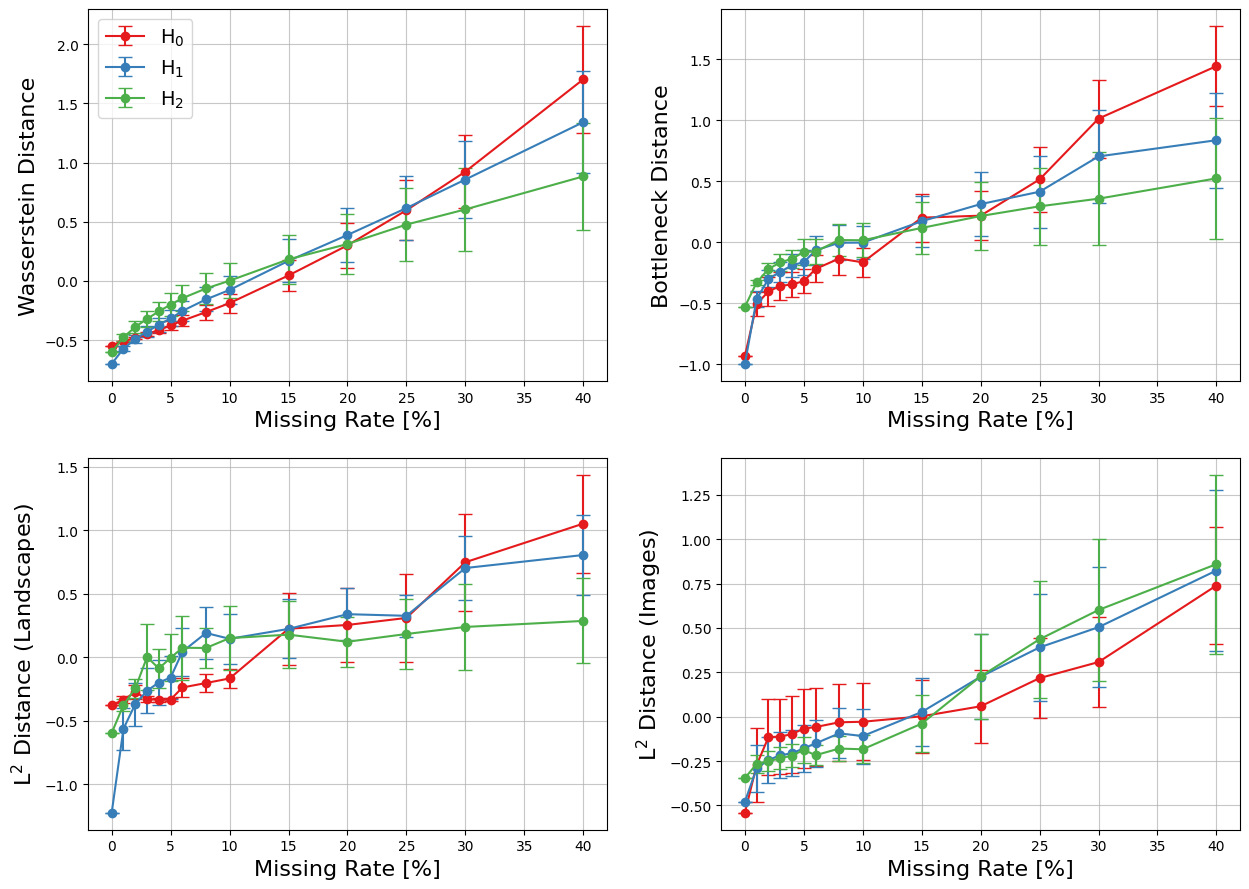

In [2]:
df = group_results(
    csv=IMPACT_MISSINGNESS,
    group=[DATASET, MISSINGNESS_TYPE, DIMENSION, MISSING_RATE],
    metrics=COLLECTIONS[TDA_METRIC],
    zeros=True
)
df = df[df[MISSINGNESS_TYPE] == MAR]

for metric in COLLECTIONS[TDA_METRIC]:
    for dim in DIMENSIONS:
        mask = df[DIMENSION] == dim
        df.loc[mask, metric] = StandardScaler().fit_transform(df.loc[mask, [metric]])

fig, axes = setup_figure(
    cells=len(COLLECTIONS[TDA_METRIC])
)
axes = axes.flatten()

for i, metric in enumerate(COLLECTIONS[TDA_METRIC]):
    ax = axes[i]

    for dim in DIMENSIONS:
        mean, sem = compute_mean_sem(
            type=MISSING_RATE,
            data=df,
            group=MISSING_RATE, 
            metric=metric,
            filter=df[DIMENSION] == dim
        )
        plot_data(
            type=MISSING_RATE,
            ax=ax, mean=mean, sem=sem,
            label=LABEL[dim], 
            color=plt.get_cmap(COLOR_MAP[DIMENSION])(dim)
        )
    
    format_axes(
        type=MISSING_RATE, 
        ax=ax,
        x_label=LABEL[MISSING_RATE],
        y_label=LABEL[metric],
        legend=i==0
    )

plot(fig, '../figures/results/mr.svg')

## Missing Rate - Dataset Type

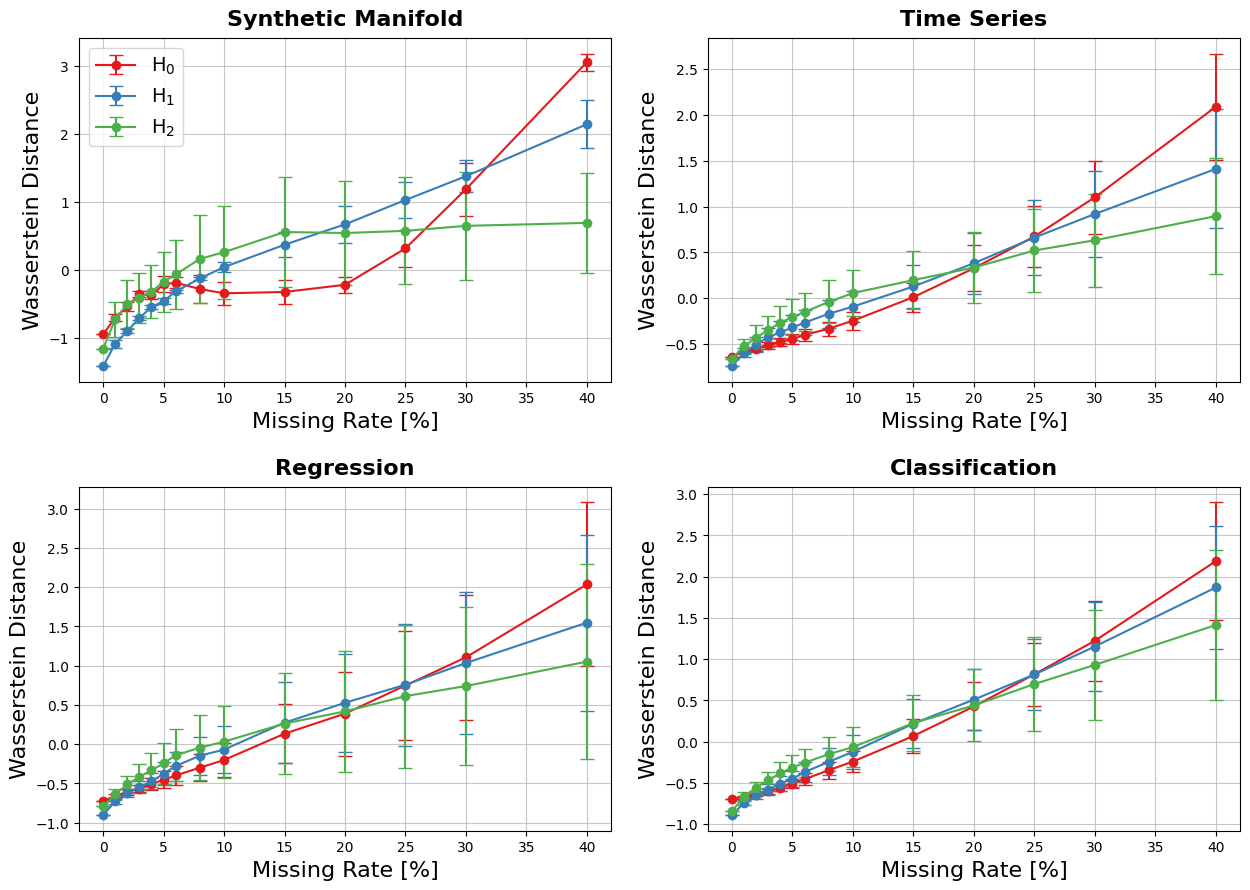

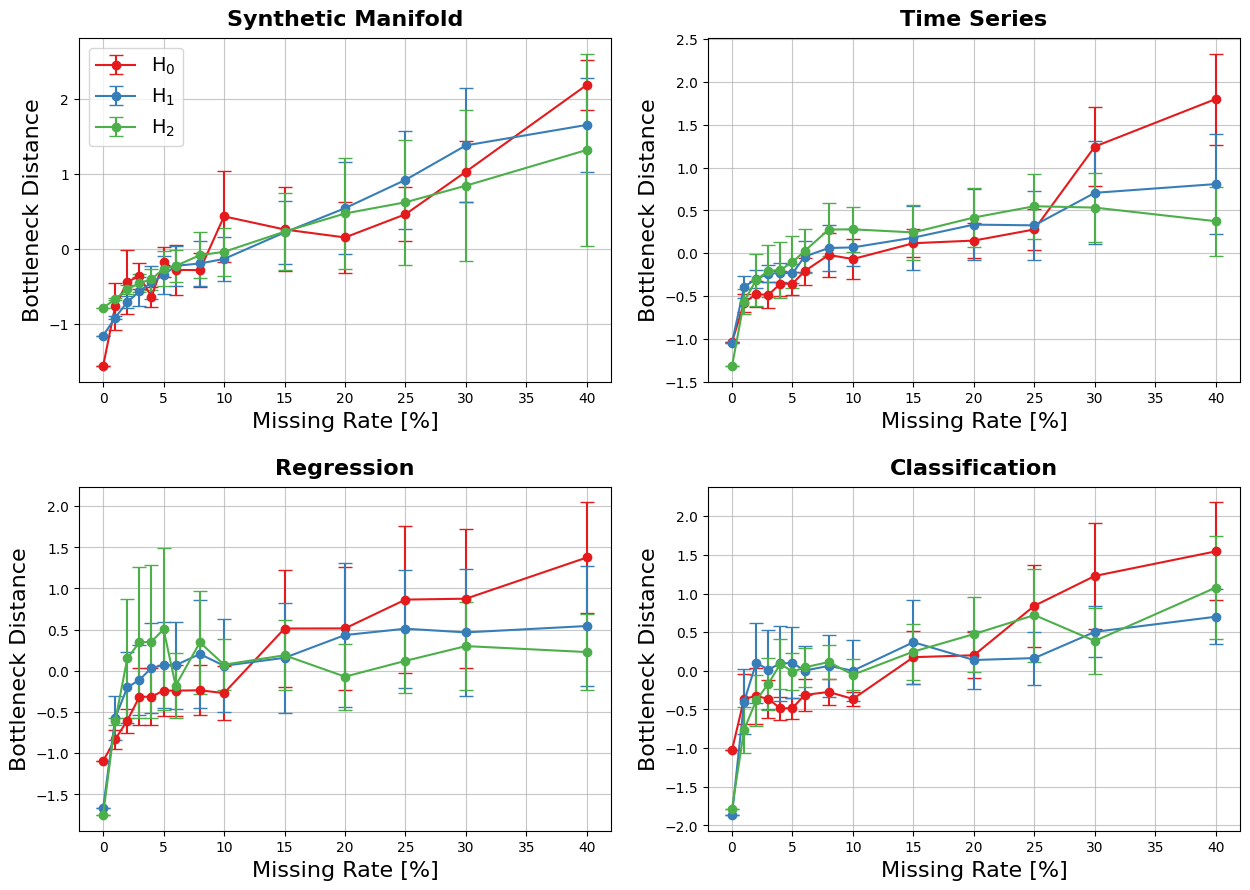

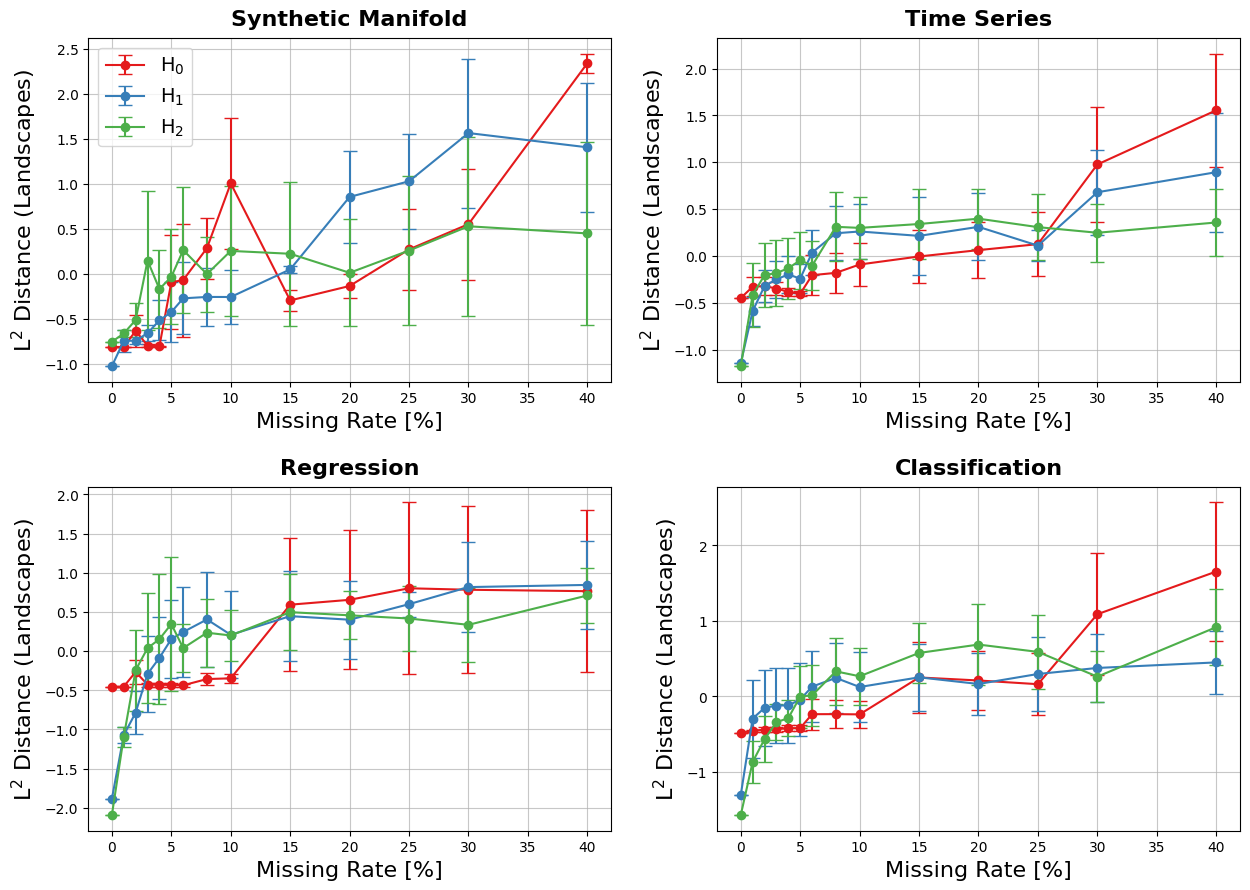

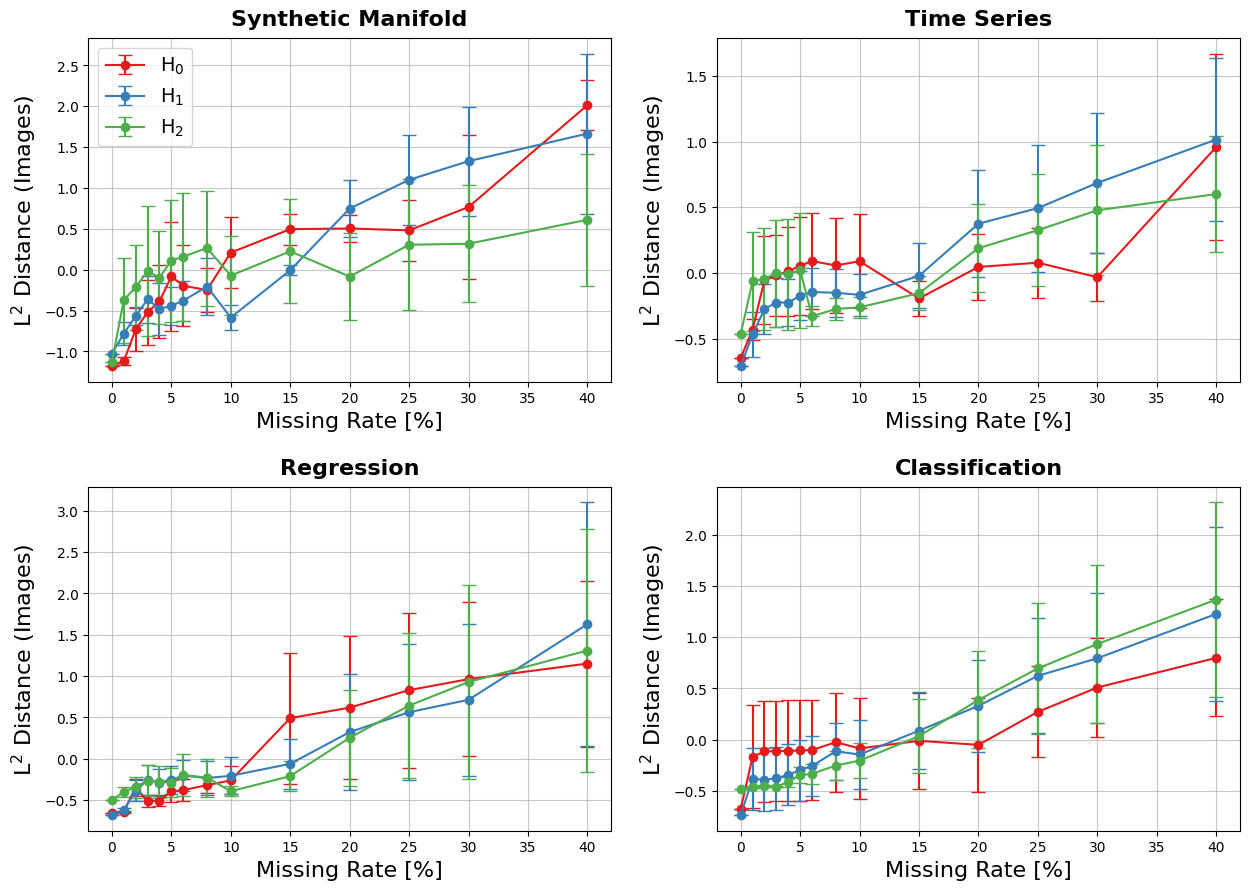

In [3]:
df = group_results(
    csv=IMPACT_MISSINGNESS,
    group=[DATASET, MISSINGNESS_TYPE, DIMENSION, MISSING_RATE],
    metrics=COLLECTIONS[TDA_METRIC],
    zeros=True
)
df = df[df[MISSINGNESS_TYPE] == MAR]

for m, metric in enumerate(COLLECTIONS[TDA_METRIC]):
    fig, axes = setup_figure(
        cells=len(COLLECTIONS[TDA_METRIC])
    )
    axes = axes.flatten()
    
    for i, dataset_type in enumerate(COLLECTIONS[DATASET_TYPE]):
        ax = axes[i]
        df_filtered = df[df[DATASET].isin(COLLECTIONS[dataset_type])].copy()

        for dim in DIMENSIONS:
            mask = df_filtered[DIMENSION] == dim
            df_filtered.loc[mask, metric] = StandardScaler().fit_transform(df_filtered.loc[mask, [metric]])

            mean, sem = compute_mean_sem(
                type=MISSING_RATE,
                data=df_filtered[mask],
                group=MISSING_RATE,
                metric=metric
            )
            plot_data(
                type=MISSING_RATE,
                ax=ax, mean=mean, sem=sem,
                label=LABEL[dim], 
                color=plt.get_cmap(COLOR_MAP[DIMENSION])(dim)
            )
        
        format_axes(
            type=MISSING_RATE, 
            ax=ax,
            x_label=LABEL[MISSING_RATE],
            y_label=LABEL[metric],
            legend=i==0
        )
        ax.text(0.5, 1.025, LABEL[dataset_type], transform=ax.transAxes, ha='center', va='bottom', fontsize=16, weight='bold')

    plot(fig, f'../figures/appendix/mr_dataset_{topological_error[m]}.svg')

## Topological Error vs Imputation Error - MAR

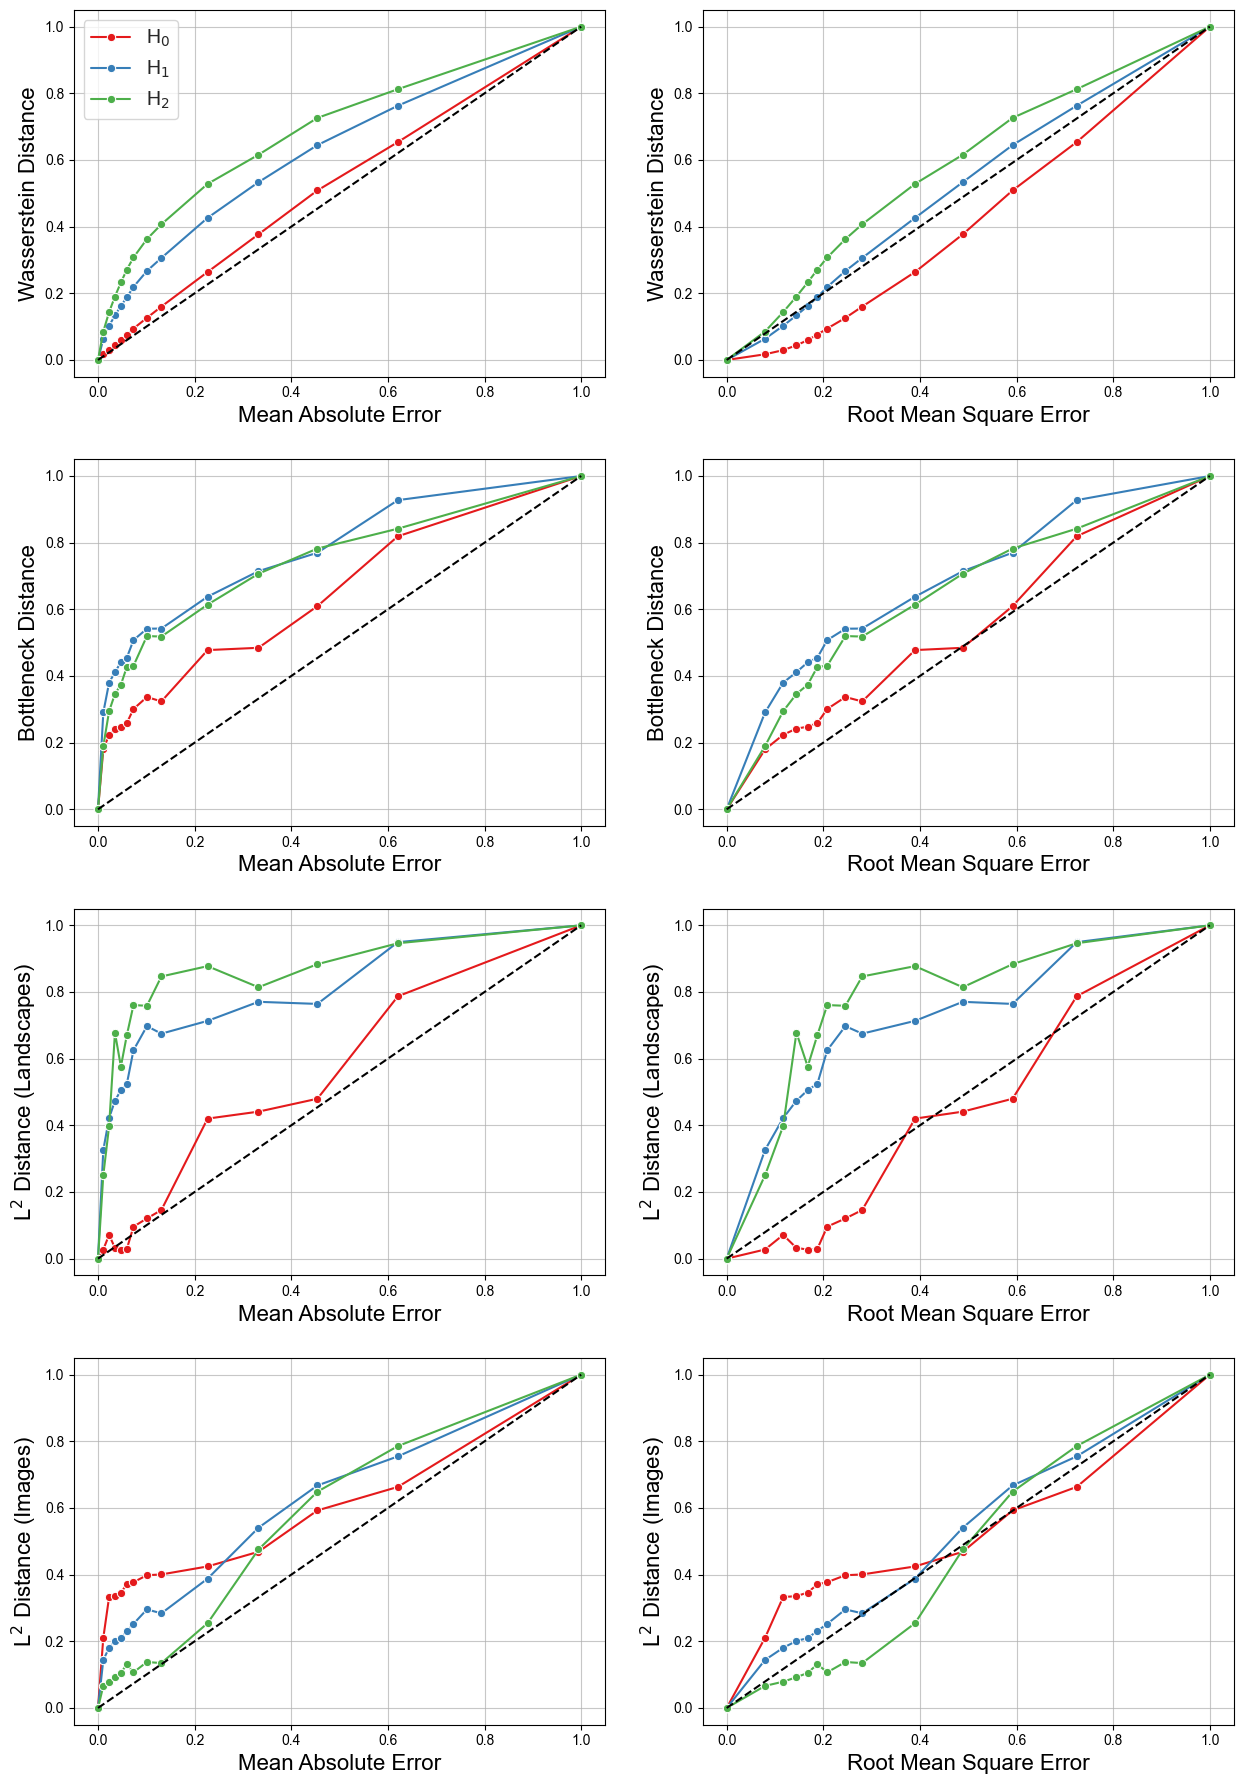

In [4]:
def plot_vs_imputatian_error(filename, scaler, filter=None, mt=MAR, tda_metrics=COLLECTIONS[TDA_METRIC]):
    df_comp = pd.read_csv(COMPARISON_METRICS)
    df_comp = (
        df_comp
        .loc[lambda df: (df[IMPUTATION_METHOD] == KNN) & (df[MISSINGNESS_TYPE] == mt)]
        .groupby([MISSING_RATE])[COLLECTIONS[METRIC]]
        .mean()
        .reset_index()
        .melt(
            id_vars=[MISSING_RATE],
            value_vars=COLLECTIONS[METRIC],
            var_name=METRIC,
            value_name=DISTANCE
        )
    )
    zeros_comp = (
        df_comp[[METRIC]]
        .drop_duplicates()
        .assign(**{MISSING_RATE: 0, DISTANCE: 0.0})
    )
    df_comp = pd.concat([df_comp, zeros_comp], ignore_index=True).sort_values([METRIC, MISSING_RATE])
    df_comp[SCALED_DISTANCE] = (
        df_comp
        .groupby(METRIC)[DISTANCE]
        .transform(lambda x: scaler.fit_transform(x.values.reshape(-1,1)).ravel())
    )
    df_comp[NORMALIZED_DISTANCE] = (
        df_comp
        .groupby([METRIC])[SCALED_DISTANCE]
        .transform(lambda x: x / x.max() if x.max() != 0 else 0)
    )

    df_tda = pd.read_csv(IMPACT_MISSINGNESS)
    if filter is not None:
        df_tda = df_tda[df_tda[DATASET].isin(filter)]
    df_tda = (
        df_tda
        .loc[lambda df: (df[IMPUTATION_METHOD] == KNN) & (df[MISSINGNESS_TYPE] == mt)]
        .groupby([DIMENSION, MISSING_RATE])[COLLECTIONS[TDA_METRIC]]
        .mean()
        .reset_index()
        .melt(
            id_vars=[DIMENSION, MISSING_RATE],
            value_vars=COLLECTIONS[TDA_METRIC],
            var_name=METRIC,
            value_name=DISTANCE
        )
    )
    zeros_tda = (
        df_tda[[DIMENSION, METRIC]]
        .drop_duplicates()
        .assign(**{MISSING_RATE: 0, DISTANCE: 0.0})
    )
    df_tda = pd.concat([df_tda, zeros_tda], ignore_index=True).sort_values([METRIC, DIMENSION, MISSING_RATE])
    df_tda[SCALED_DISTANCE] = (
        df_tda
        .groupby(METRIC)[DISTANCE]
        .transform(lambda x: scaler.fit_transform(x.values.reshape(-1,1)).ravel())
    )
    df_tda[NORMALIZED_DISTANCE] = (
        df_tda
        .groupby([METRIC, DIMENSION])[SCALED_DISTANCE]
        .transform(lambda x: x / x.max() if x.max() != 0 else 0)
    )

    merged_list = []
    for tda_metric in COLLECTIONS[TDA_METRIC]:
        for metric in COLLECTIONS[METRIC]:
            classical_df = df_comp[df_comp[METRIC] == metric][[MISSING_RATE, NORMALIZED_DISTANCE]].rename(columns={NORMALIZED_DISTANCE: 'COMP'})
            tda_df = df_tda[df_tda[METRIC] == tda_metric][[DIMENSION, MISSING_RATE, NORMALIZED_DISTANCE]].rename(columns={NORMALIZED_DISTANCE: 'TDA'})

            merged = tda_df.merge(classical_df, on=MISSING_RATE)
            merged[TDA_ERROR] = tda_metric
            merged[COMP_ERROR] = metric
            merged_list.append(merged)

    df_merged_all = pd.concat(merged_list, ignore_index=True)
    df_long = df_merged_all.melt(
        id_vars=[DIMENSION, MISSING_RATE, TDA_ERROR, COMP_ERROR],
        value_vars=['COMP', 'TDA'],
        var_name=DATASET_TYPE,
        value_name=NORMALIZED_DISTANCE
    )
    pivoted = (
        df_long
        .pivot_table(
            index=[DIMENSION, MISSING_RATE, TDA_ERROR, COMP_ERROR],
            columns=DATASET_TYPE,
            values=NORMALIZED_DISTANCE
        )
        .reset_index()
        .dropna()
    )

    fig, axes = setup_figure(
        rows=len(tda_metrics), 
        cols=len(COLLECTIONS[METRIC])
    )
    sns.set(style="whitegrid")

    for i, tda_metric in enumerate(tda_metrics):
        for j, comp_metric in enumerate(COLLECTIONS[METRIC]):
            ax = axes[i][j]
            subset = pivoted[(pivoted[TDA_ERROR] == tda_metric) & (pivoted[COMP_ERROR] == comp_metric)]
        
            for dim in DIMENSIONS:
                dim_data = subset[subset[DIMENSION] == dim]
                sns.lineplot(
                    data=dim_data,
                    x='COMP',
                    y='TDA',
                    ax=ax,
                    marker='o',
                    label=LABEL[dim],
                    color=sns.color_palette(COLOR_MAP[DIMENSION], n_colors=len(DIMENSIONS))[dim],
                    legend=False
                )
            
            format_axes(
                type=MISSING_RATE,
                ax=ax,
                x_label=LABEL[comp_metric],
                y_label=LABEL[tda_metric],
                legend=(i==0 and j==0)
            )
            ax.plot([0, 1], [0, 1], linestyle='--', color='black')

    plot(fig, filename)

plot_vs_imputatian_error('../figures/results/tda_vs_imp.svg', MinMaxScaler())

## Topological Error vs Imputation Error - MCAR & Synthetic Manifolds

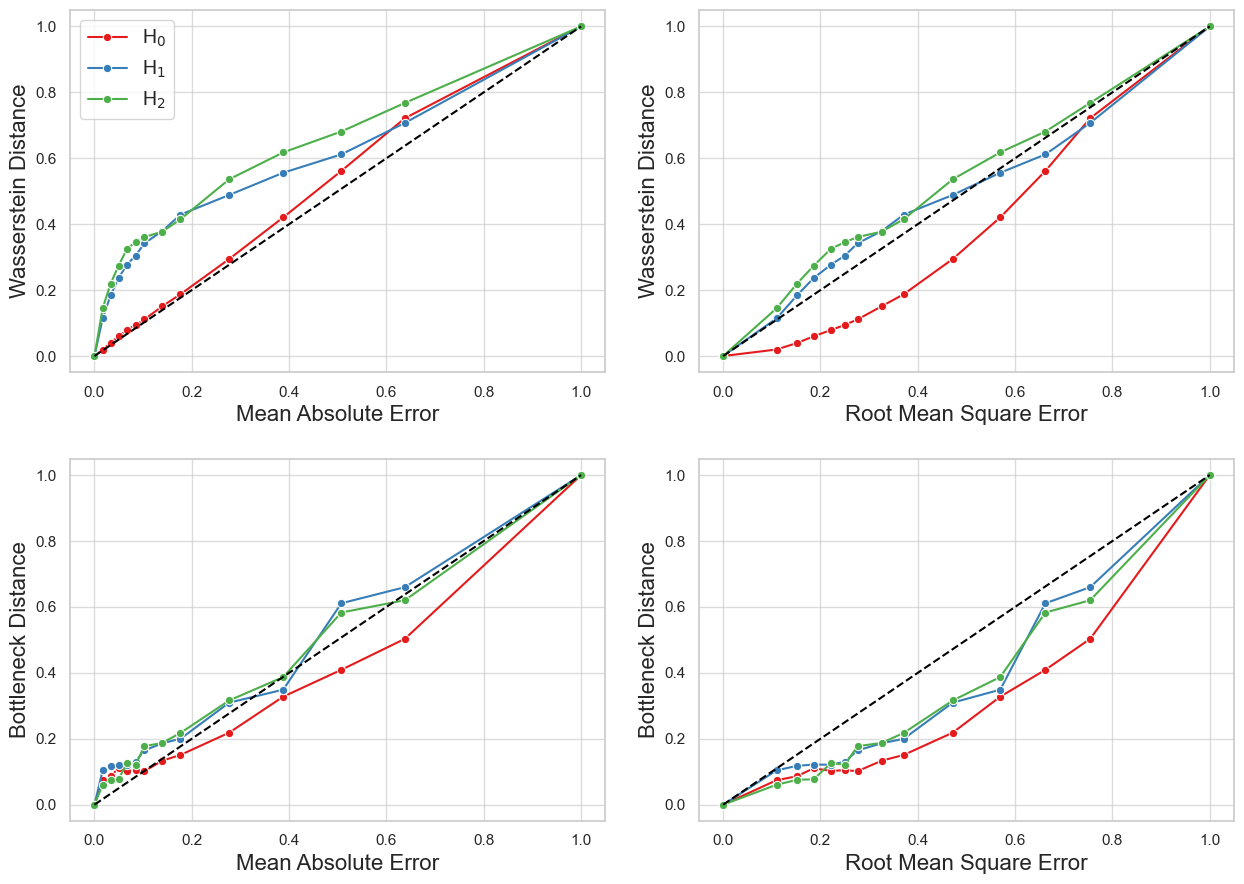

In [5]:
plot_vs_imputatian_error('../figures/analysis/mcar_vs_imputation_error.svg', MinMaxScaler(), COLLECTIONS[MANIFOLD], MCAR, COLLECTIONS[TDA_METRIC_SHORT])

## Missingness Type - General

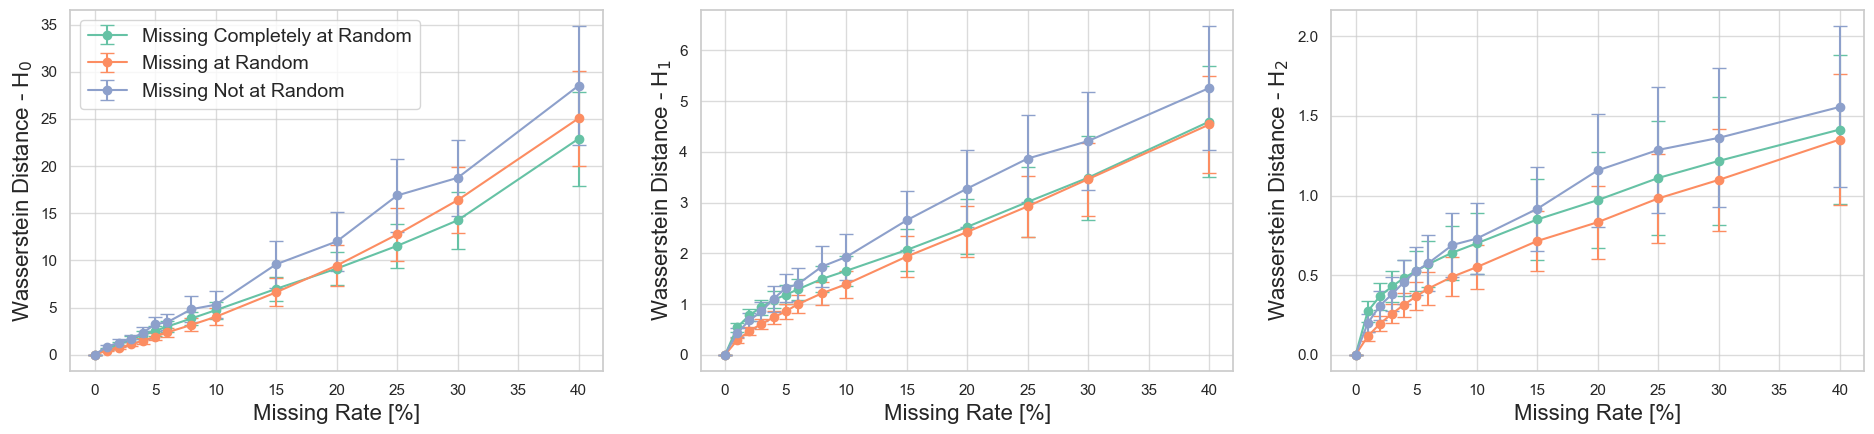

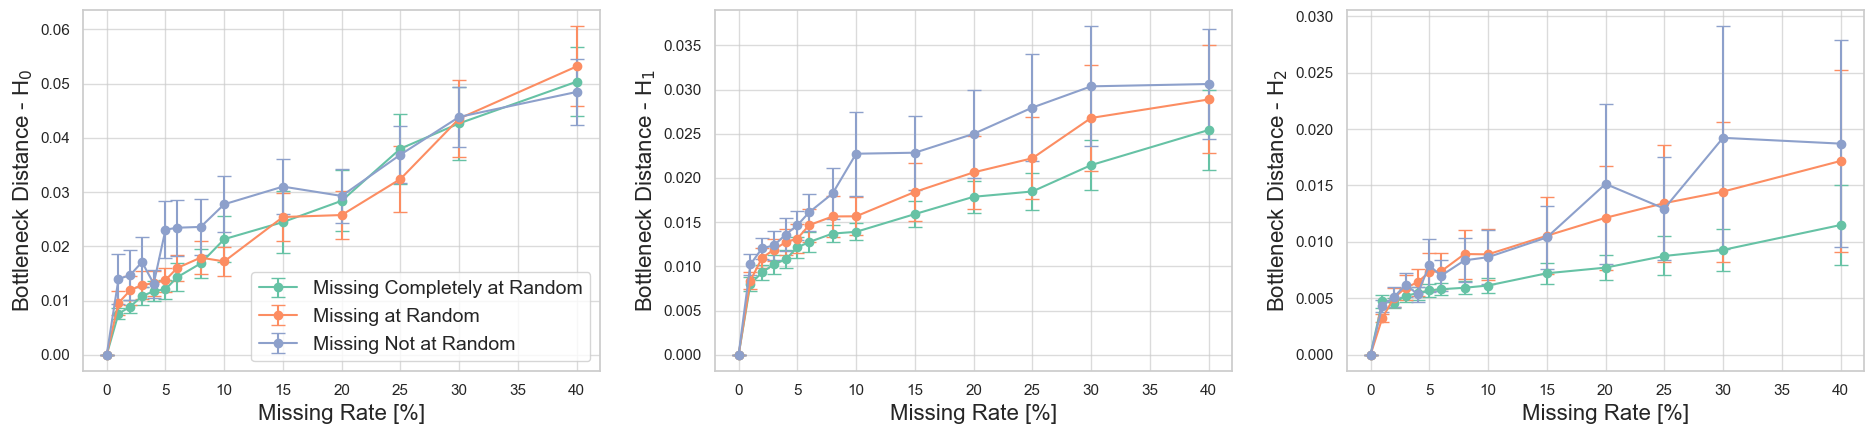

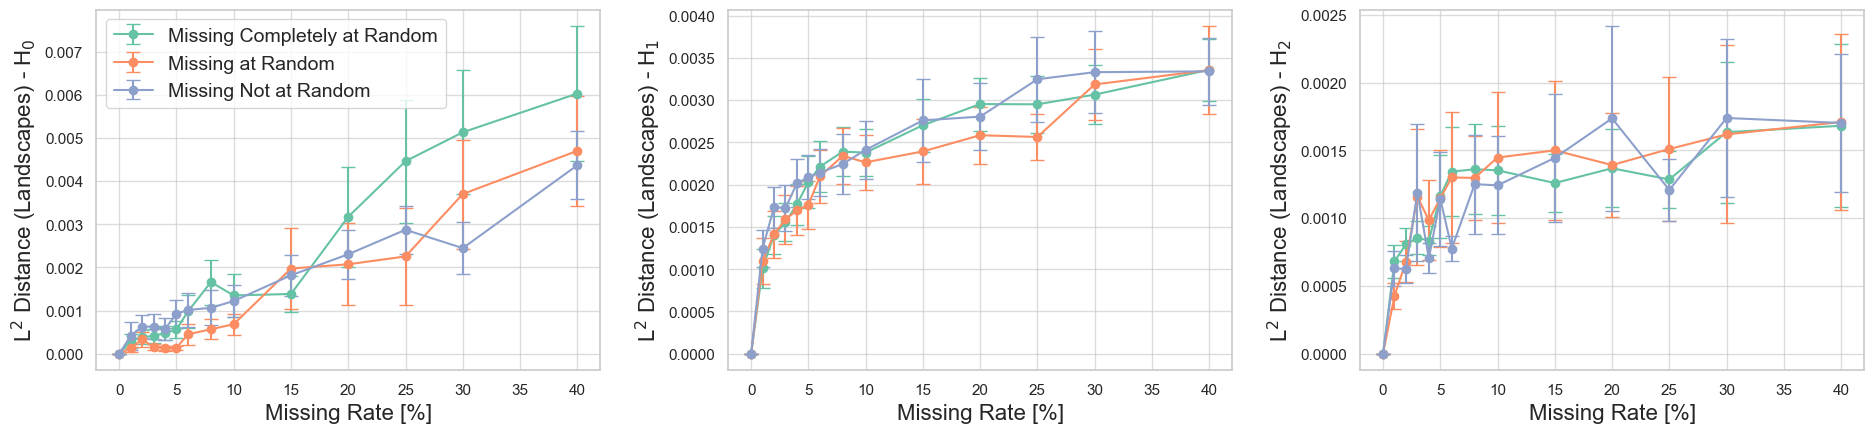

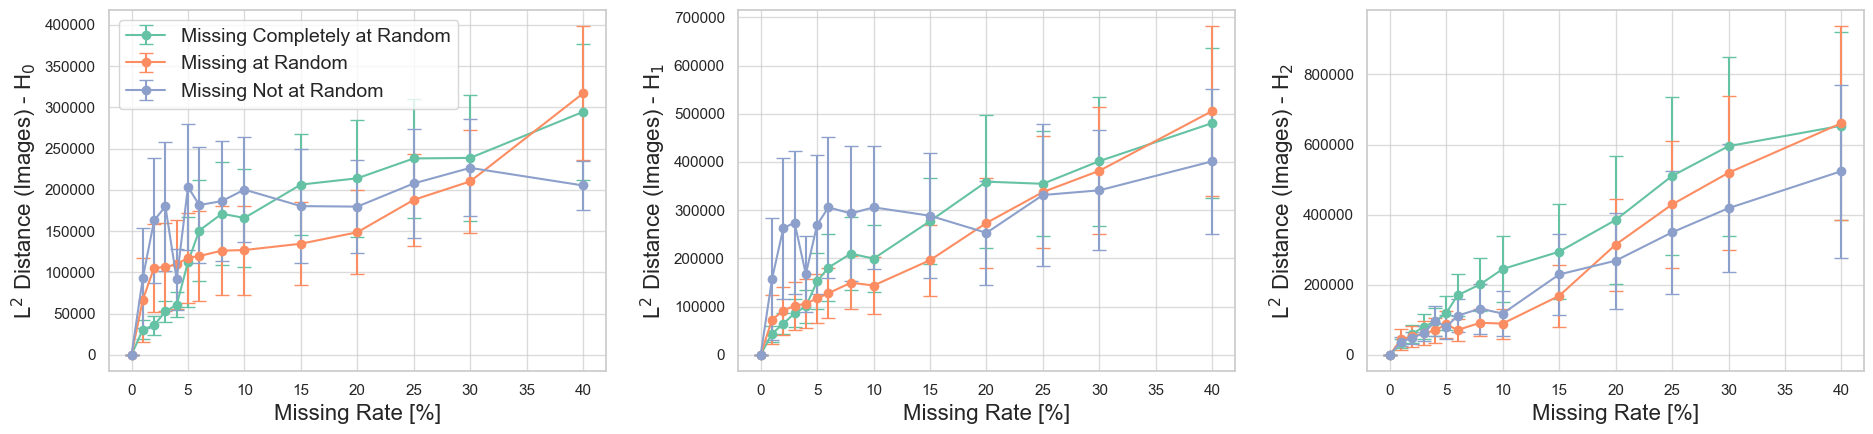

In [6]:
df = group_results(
    csv=IMPACT_MISSINGNESS,
    group=[DATASET, MISSINGNESS_TYPE, DIMENSION, MISSING_RATE],
    metrics=COLLECTIONS[TDA_METRIC],
    zeros=True
)

for m, metric in enumerate(COLLECTIONS[TDA_METRIC]):
    fig, axes = setup_figure(
        rows=1,
        cols=len(DIMENSIONS)
    )
    axes = axes.flatten()

    for dim in DIMENSIONS:
        ax = axes[dim]
        
        for mt in COLLECTIONS[MISSINGNESS_TYPE]:
            mean, sem = compute_mean_sem(
                type=MISSINGNESS_TYPE,
                data=df,
                group=MISSING_RATE, 
                metric=metric,
                filter=(df[DIMENSION] == dim) & (df[MISSINGNESS_TYPE] == mt)
            )
            plot_data(
                type=MISSINGNESS_TYPE,
                ax=ax, mean=mean, sem=sem,
                label=LABEL[mt],
                color=plt.get_cmap(COLOR_MAP[MISSINGNESS_TYPE])(COLLECTIONS[MISSINGNESS_TYPE].index(mt))
            )

        format_axes(
            type=MISSINGNESS_TYPE, 
            ax=ax,
            x_label=LABEL[MISSING_RATE],
            y_label=f'{LABEL[metric]} - {LABEL[dim]}',
            legend=dim==0
        )

    plot(fig, f'../figures/results/mt_{topological_error[m]}.svg')

## Missingness Type - Dataset Type

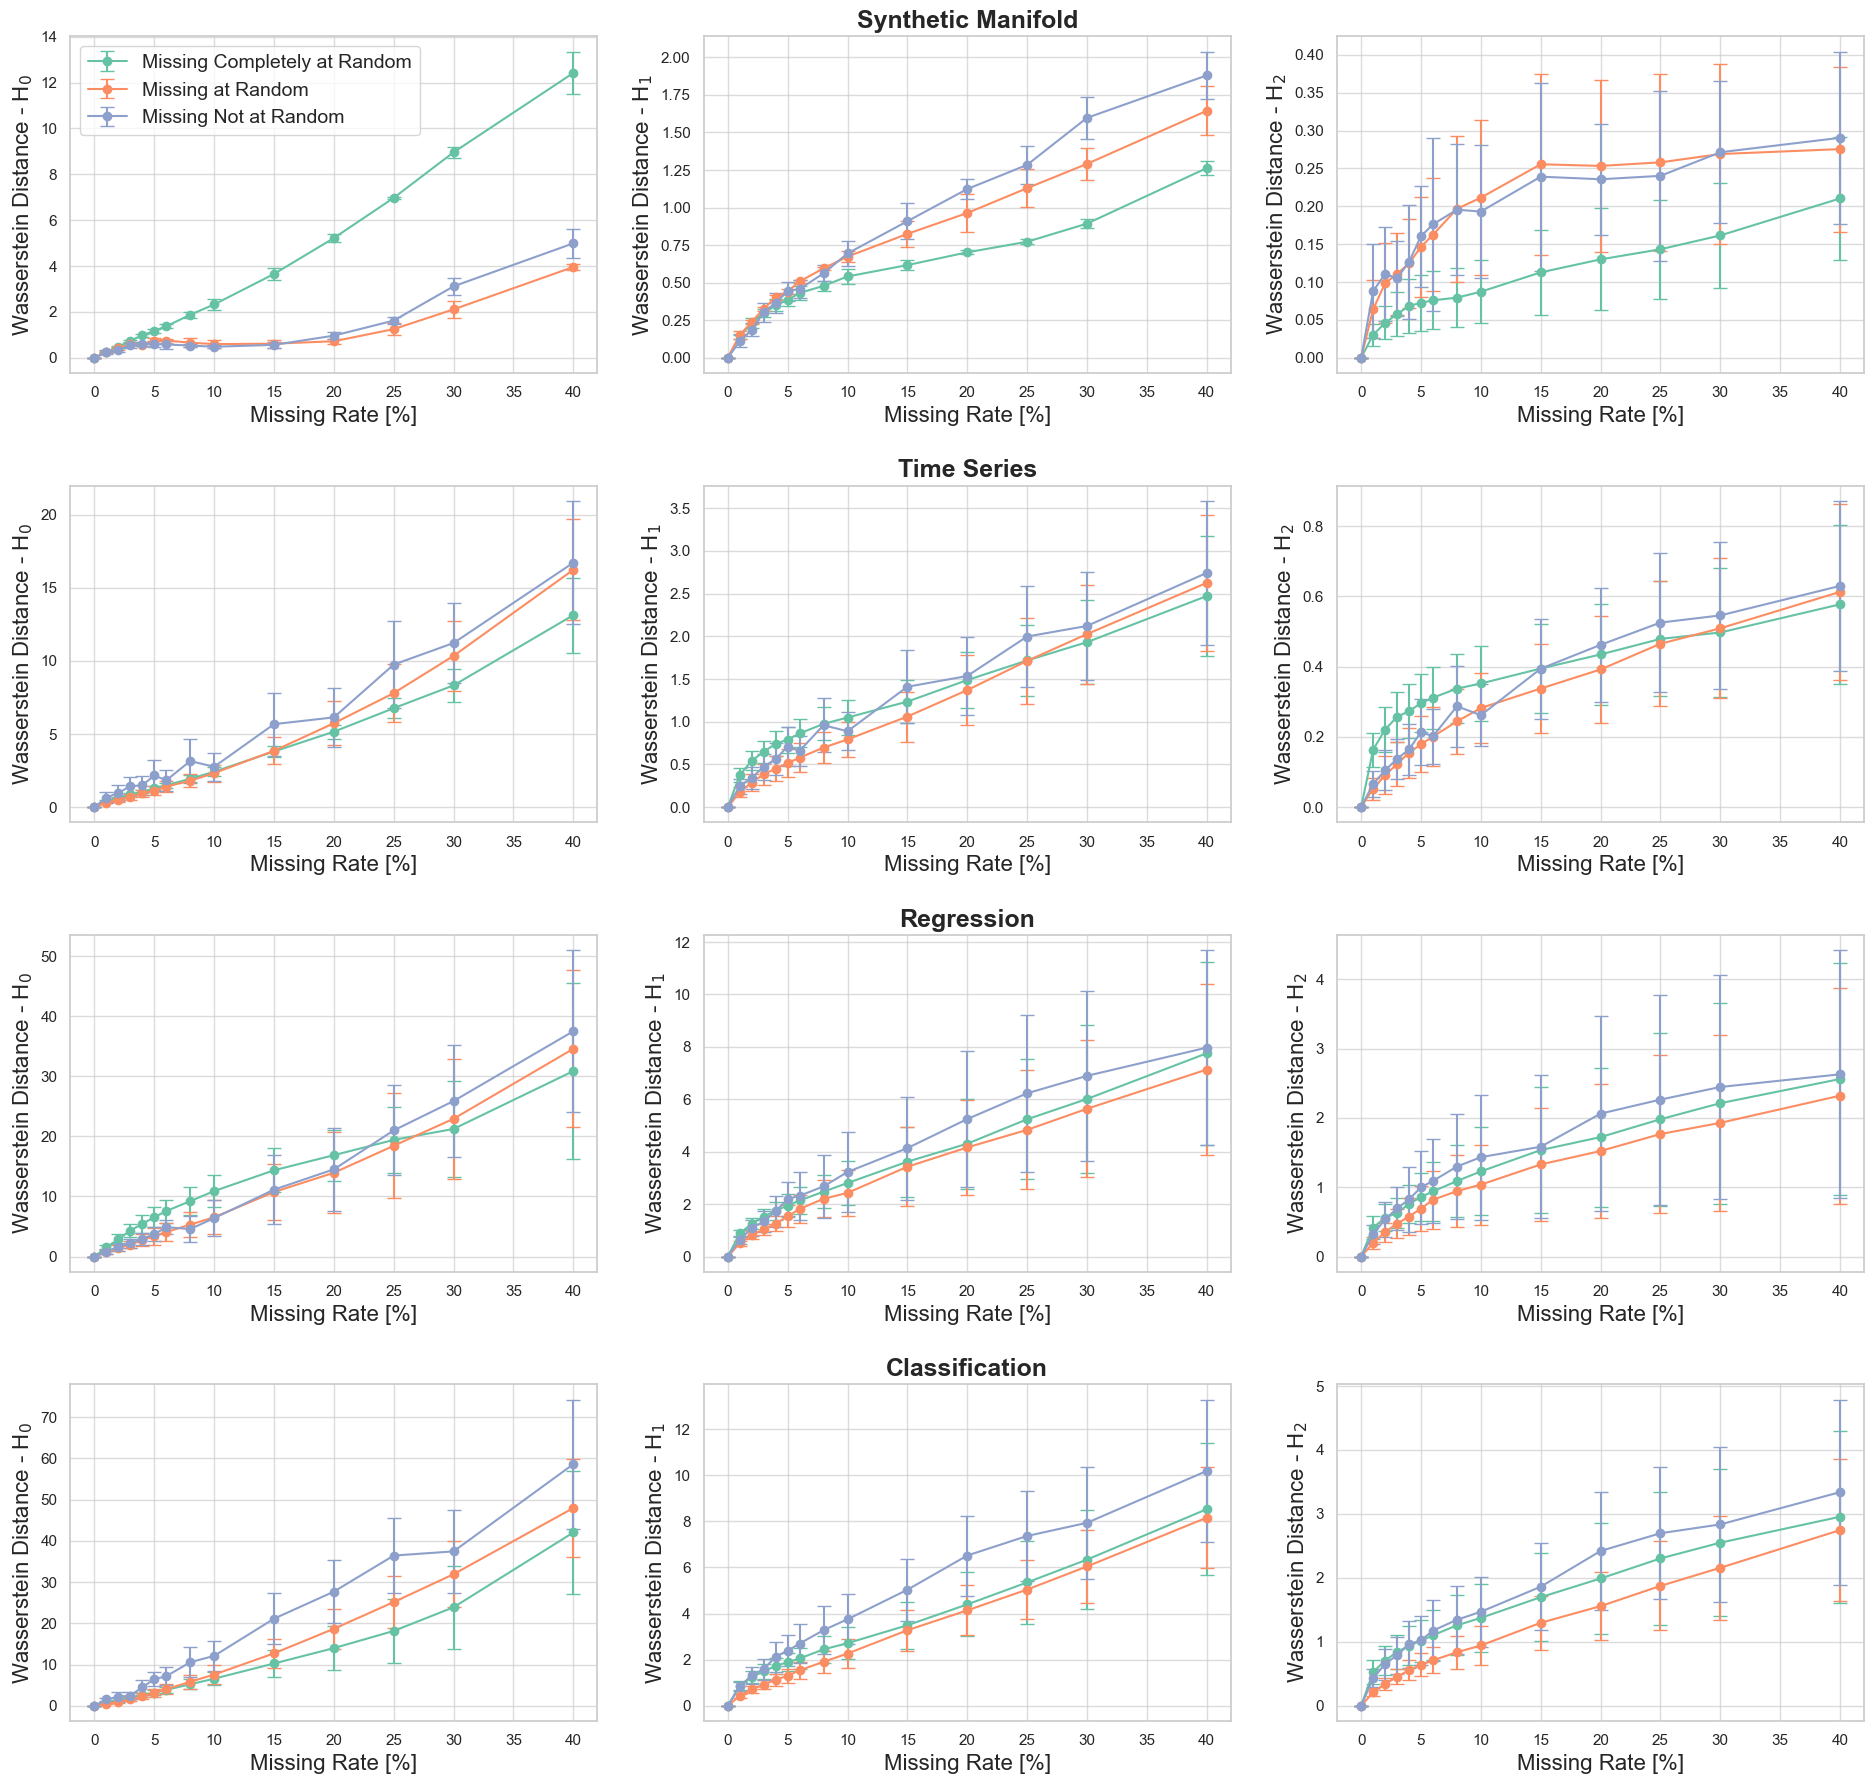

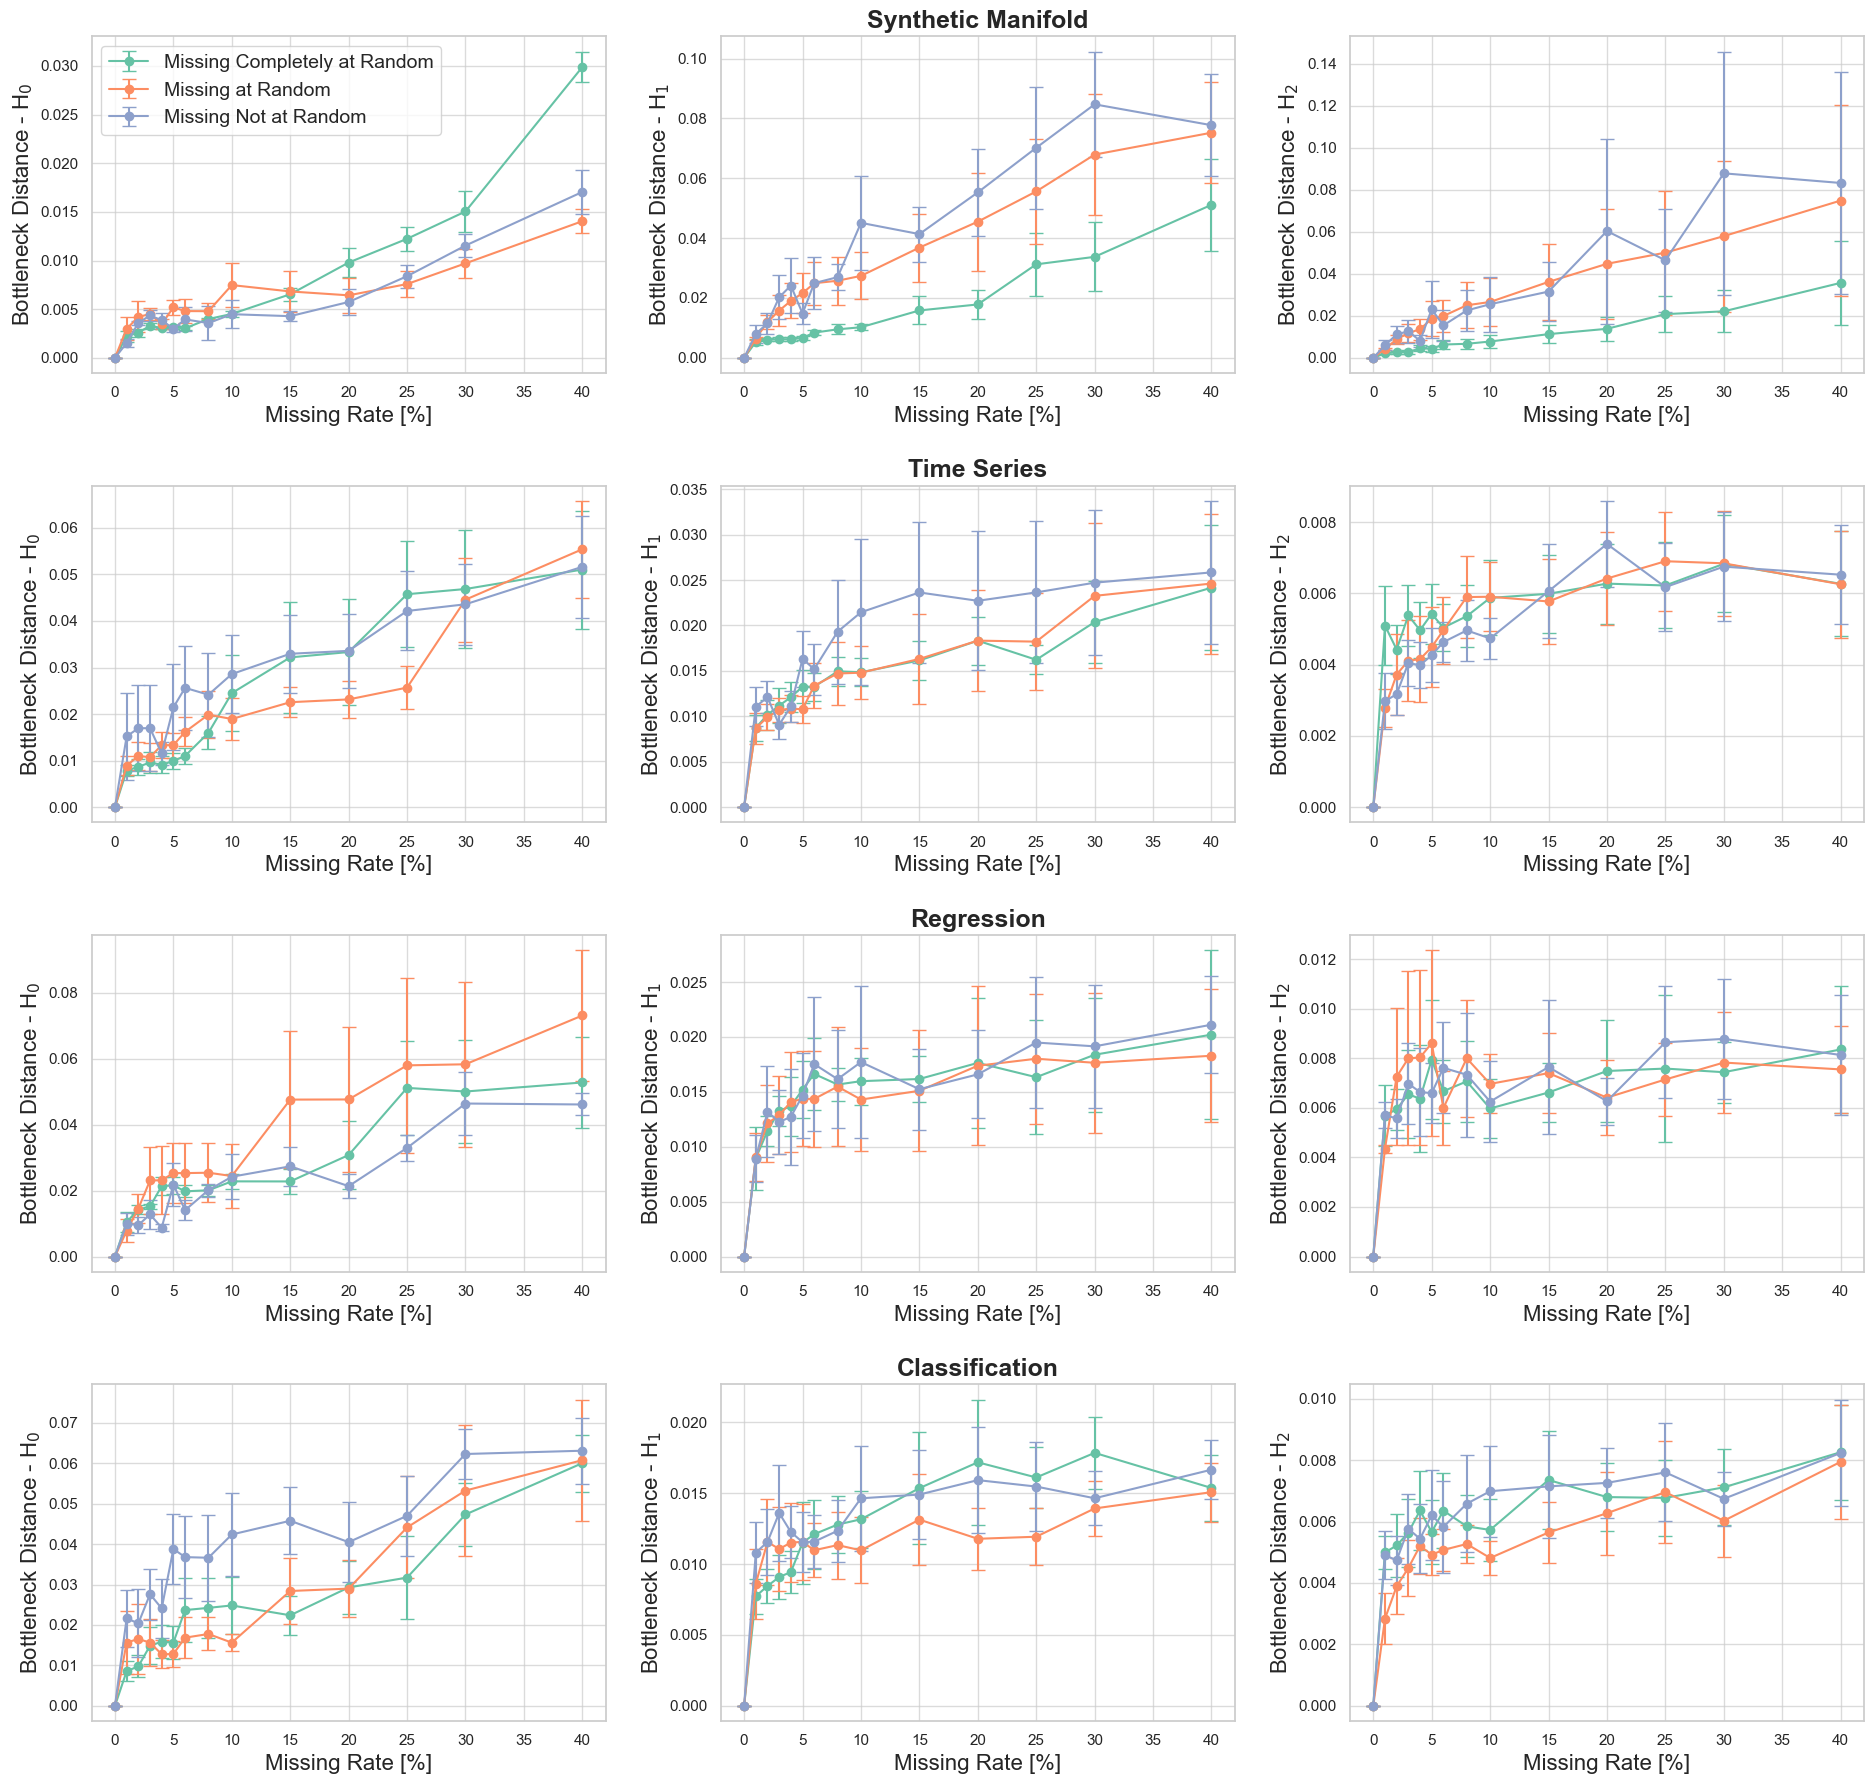

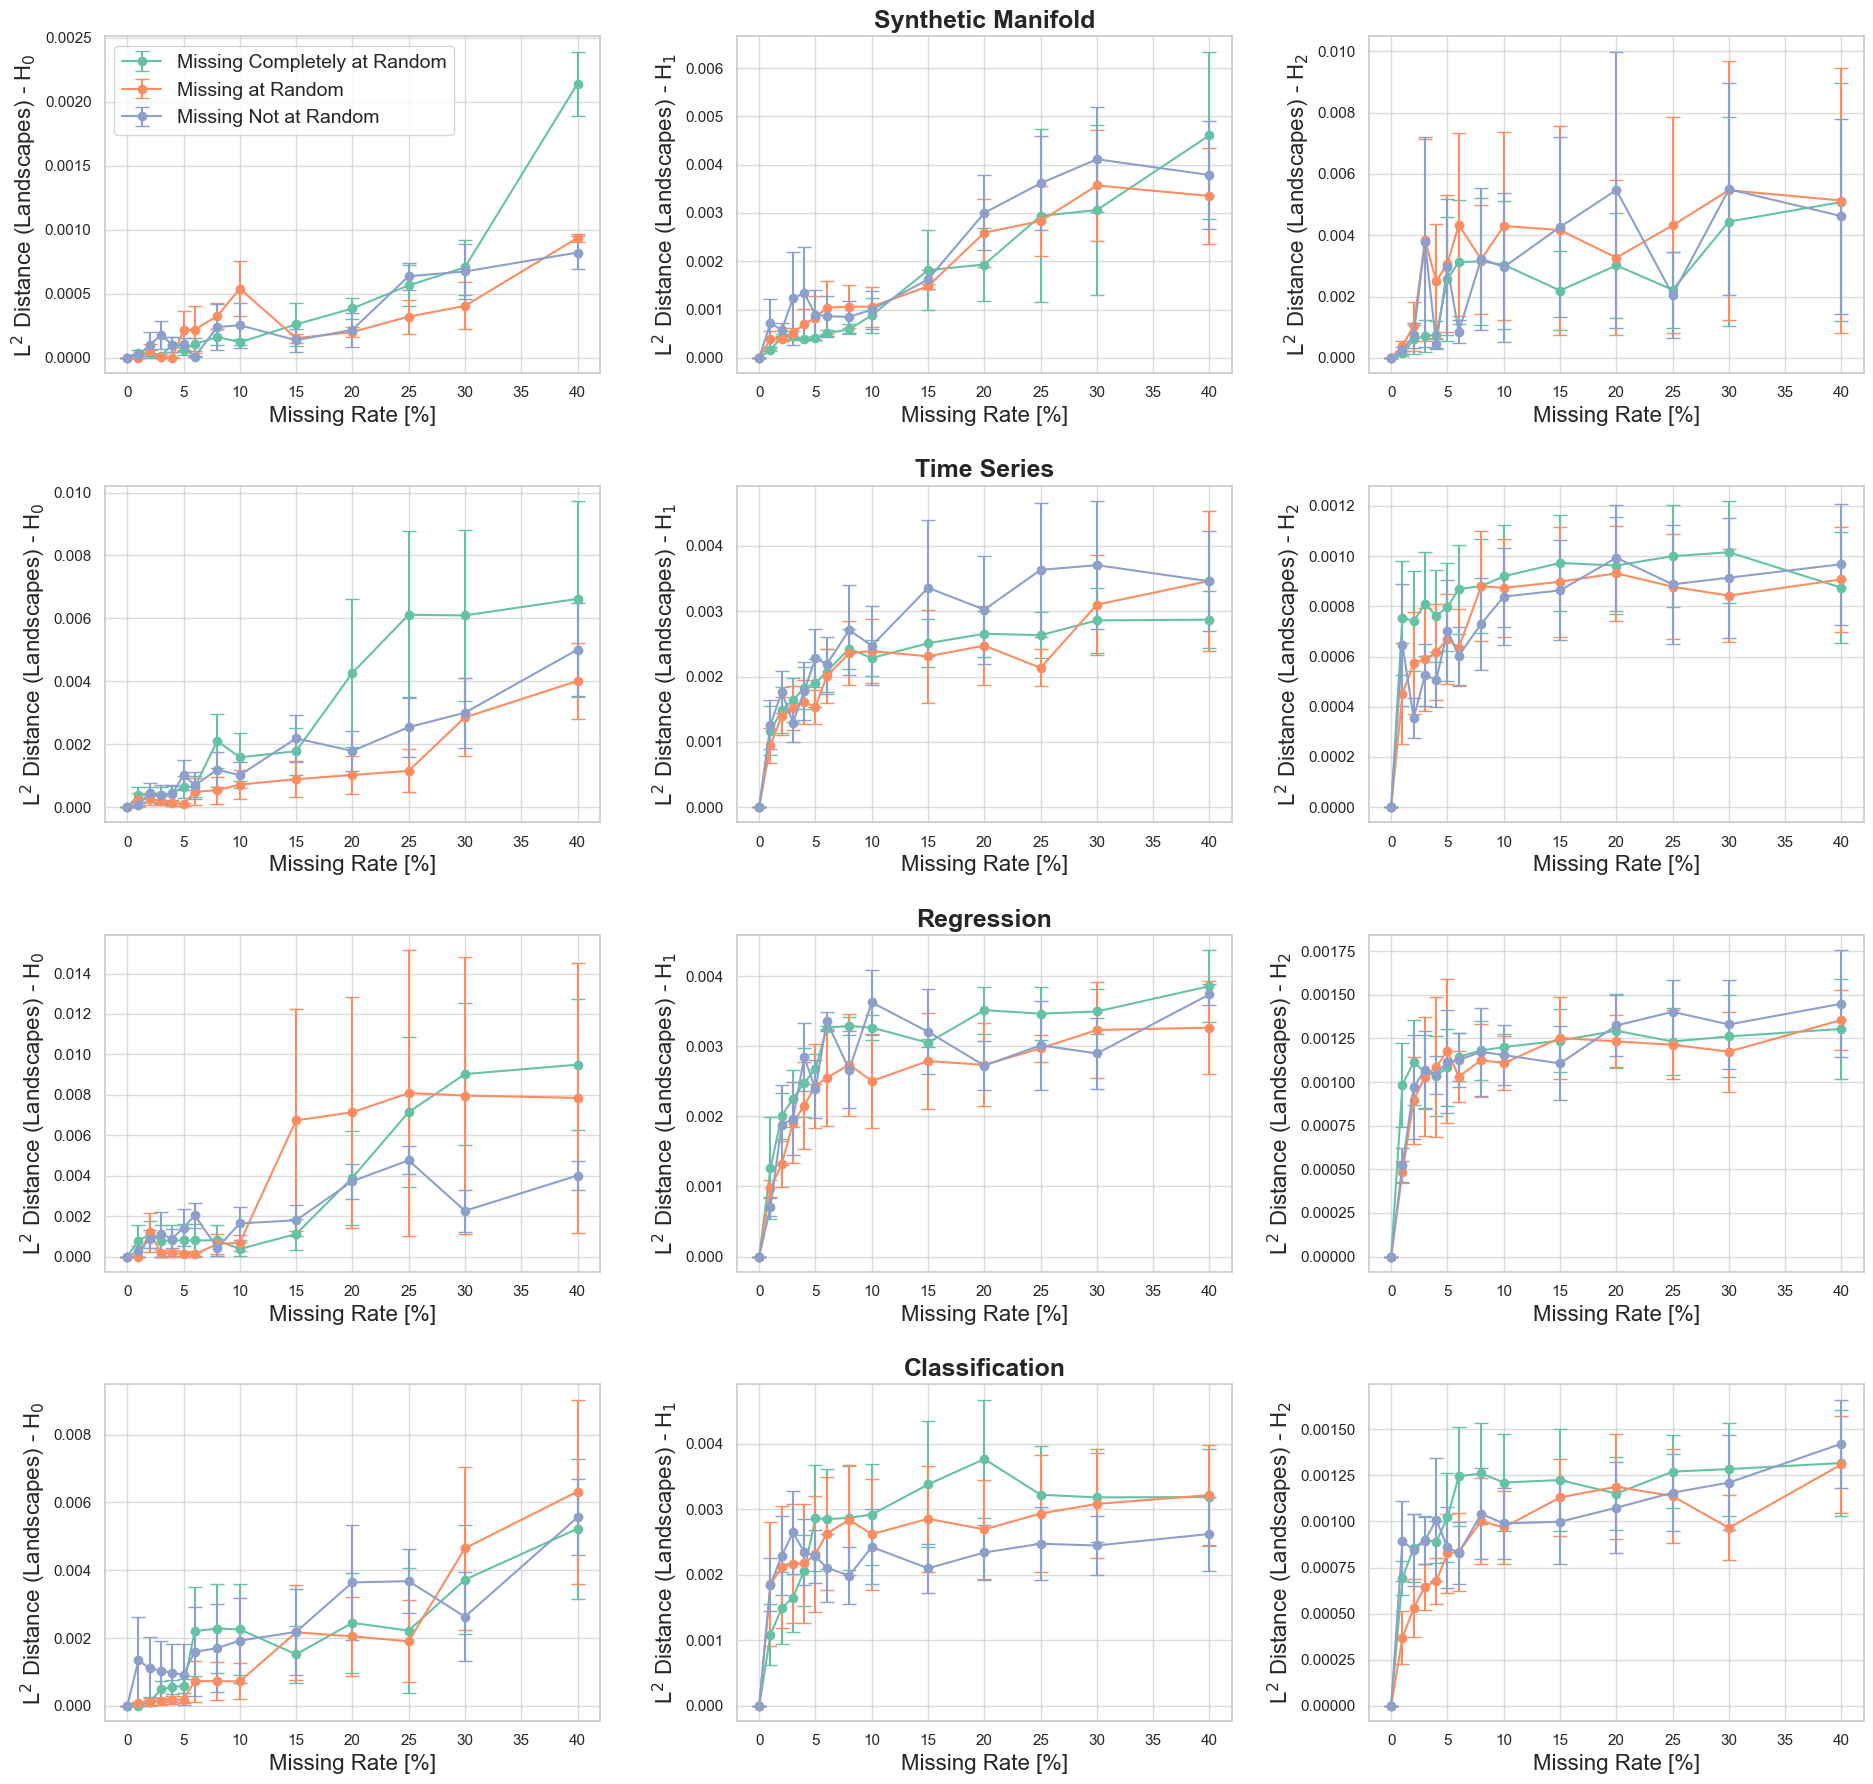

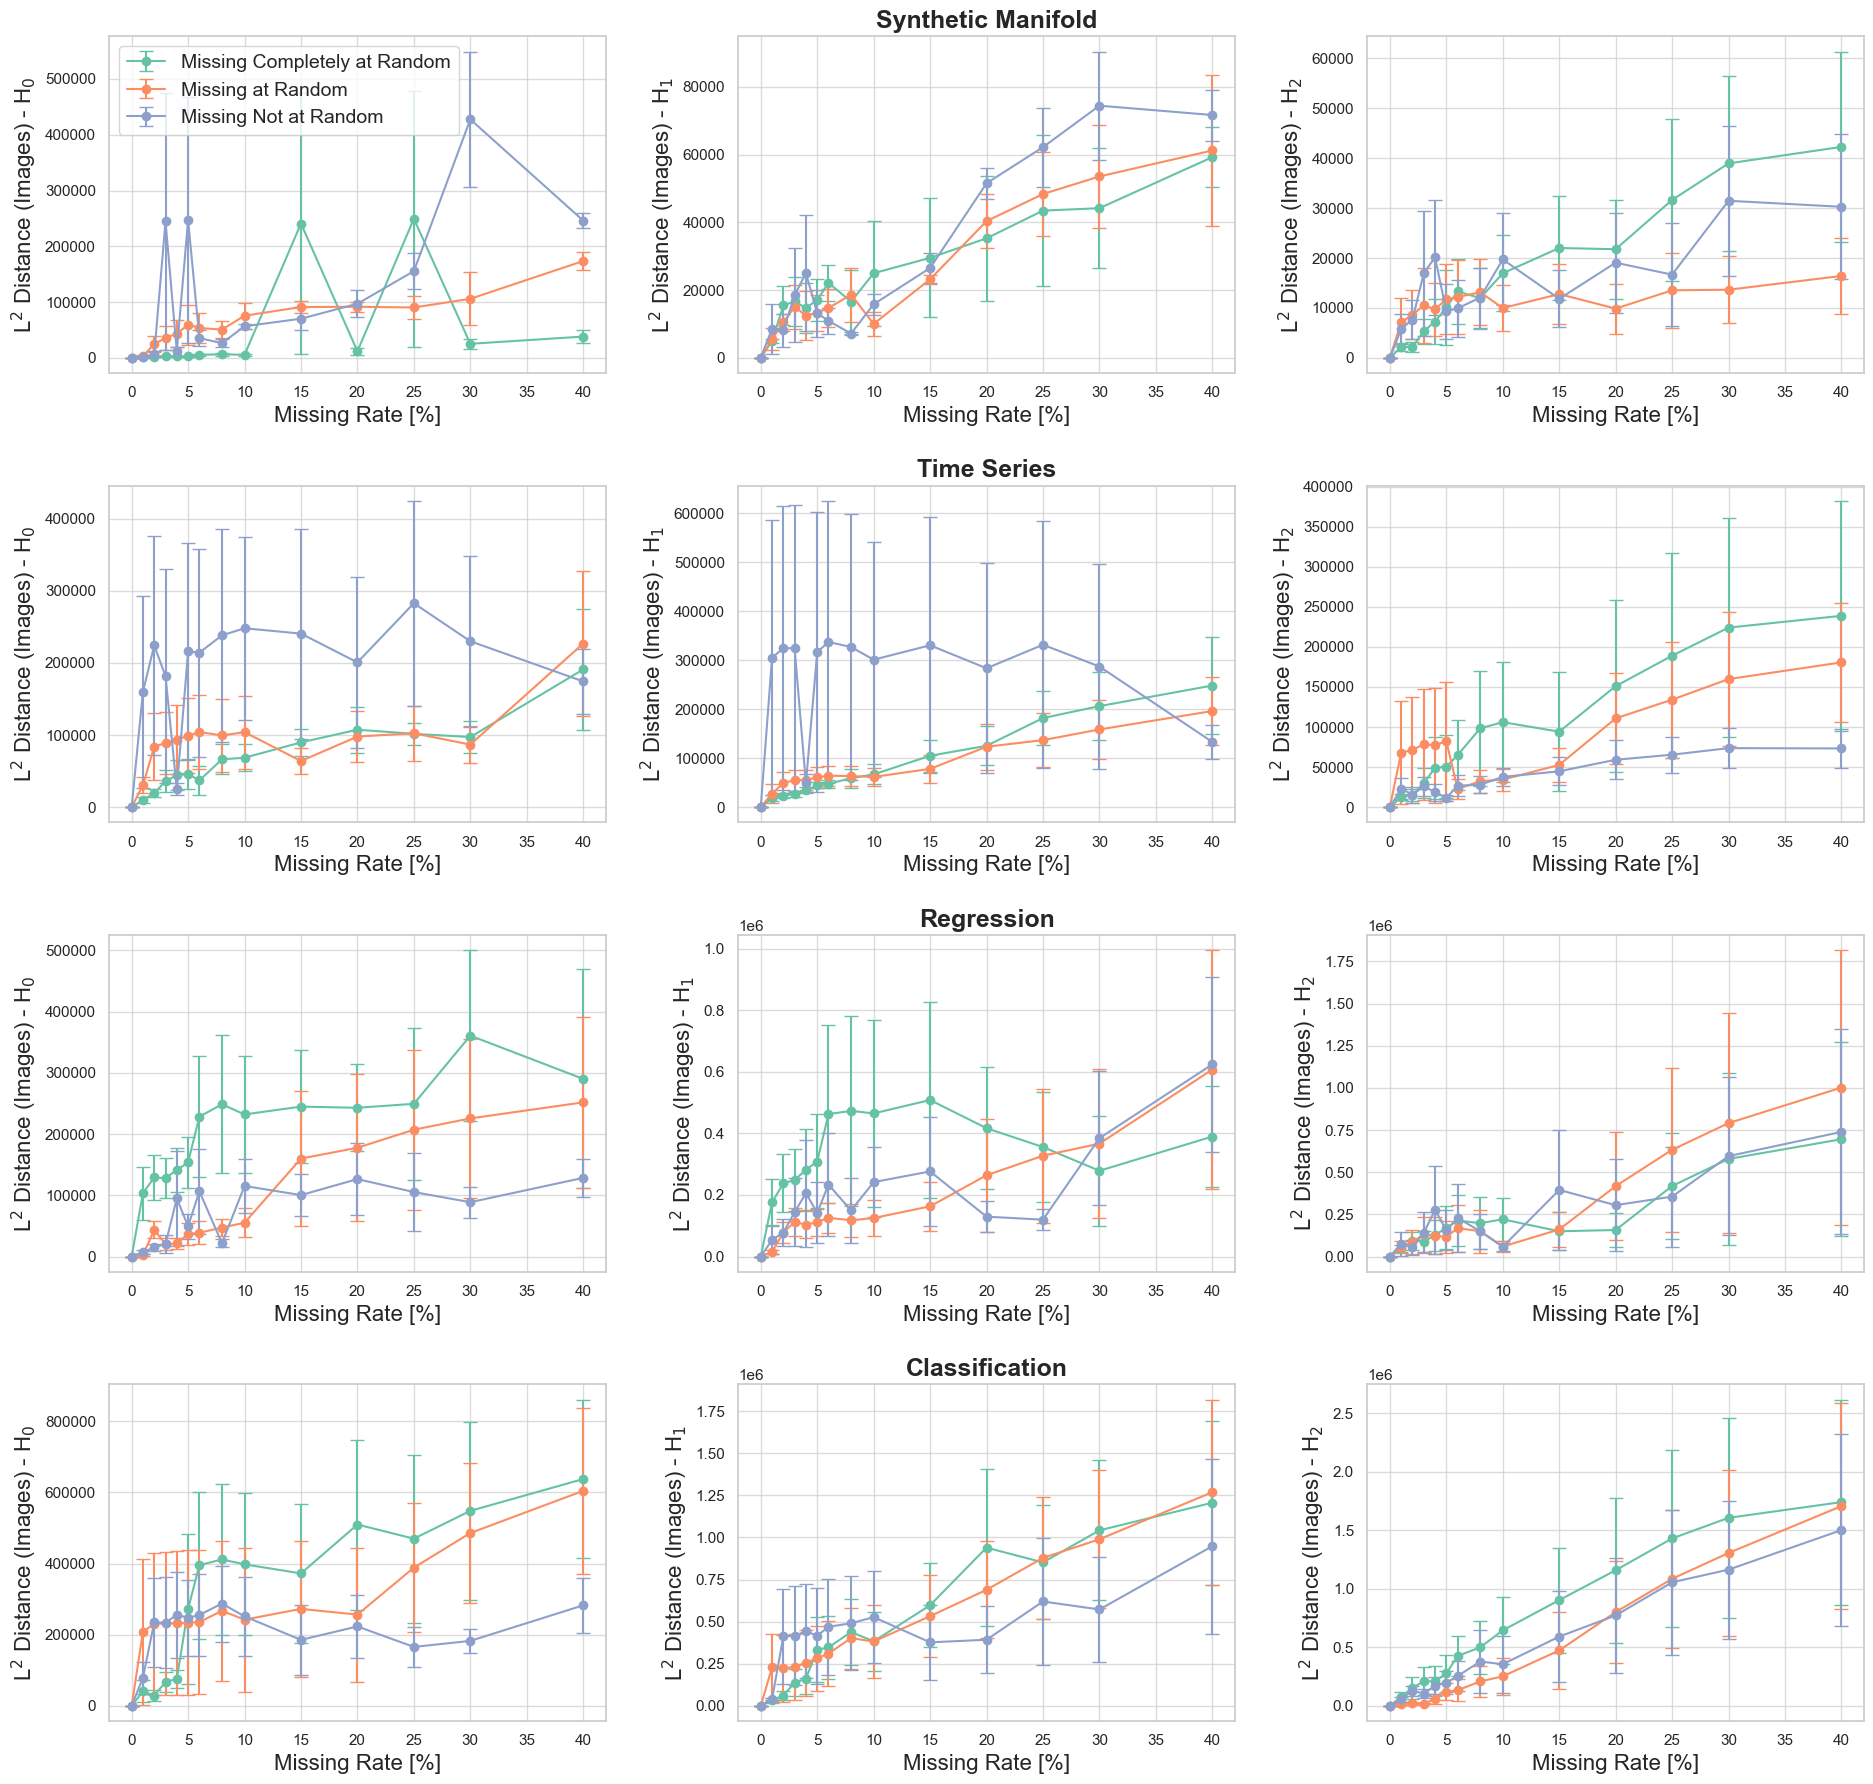

In [7]:
df = group_results(
    csv=IMPACT_MISSINGNESS,
    group=[DATASET, MISSINGNESS_TYPE, DIMENSION, MISSING_RATE],
    metrics=COLLECTIONS[TDA_METRIC],
    zeros=True
)

for m, metric in enumerate(COLLECTIONS[TDA_METRIC]):
    fig, axes = setup_figure(
        rows=len(COLLECTIONS[DATASET_TYPE]),
        cols=len(DIMENSIONS)
    )

    for i, dataset_type in enumerate(COLLECTIONS[DATASET_TYPE]):
        df_filtered = df[(df[DATASET].isin(COLLECTIONS[dataset_type]))].copy()        
        for dim in DIMENSIONS:
            ax = axes[i][dim]
            for mt in COLLECTIONS[MISSINGNESS_TYPE]:
                mean, sem = compute_mean_sem(
                    type=MISSINGNESS_TYPE,
                    data=df_filtered,
                    group=MISSING_RATE, 
                    metric=metric,
                    filter=(df_filtered[DIMENSION] == dim) & (df_filtered[MISSINGNESS_TYPE] == mt)
                )
                plot_data(
                    type=MISSINGNESS_TYPE,
                    ax=ax, mean=mean, sem=sem,
                    label=LABEL[mt],
                    color=plt.get_cmap(COLOR_MAP[MISSINGNESS_TYPE])(COLLECTIONS[MISSINGNESS_TYPE].index(mt))
                )

            format_axes(
                type=MISSINGNESS_TYPE, 
                ax=ax,
                x_label=LABEL[MISSING_RATE],
                y_label=f'{LABEL[metric]} - {LABEL[dim]}',
                legend=i==0 and dim==0,
                title=dim==1,
                title_label=LABEL[dataset_type]
            )

    plot(fig, f'../figures/appendix/mt_dataset_{topological_error[m]}.svg')

## Imputation Method - General

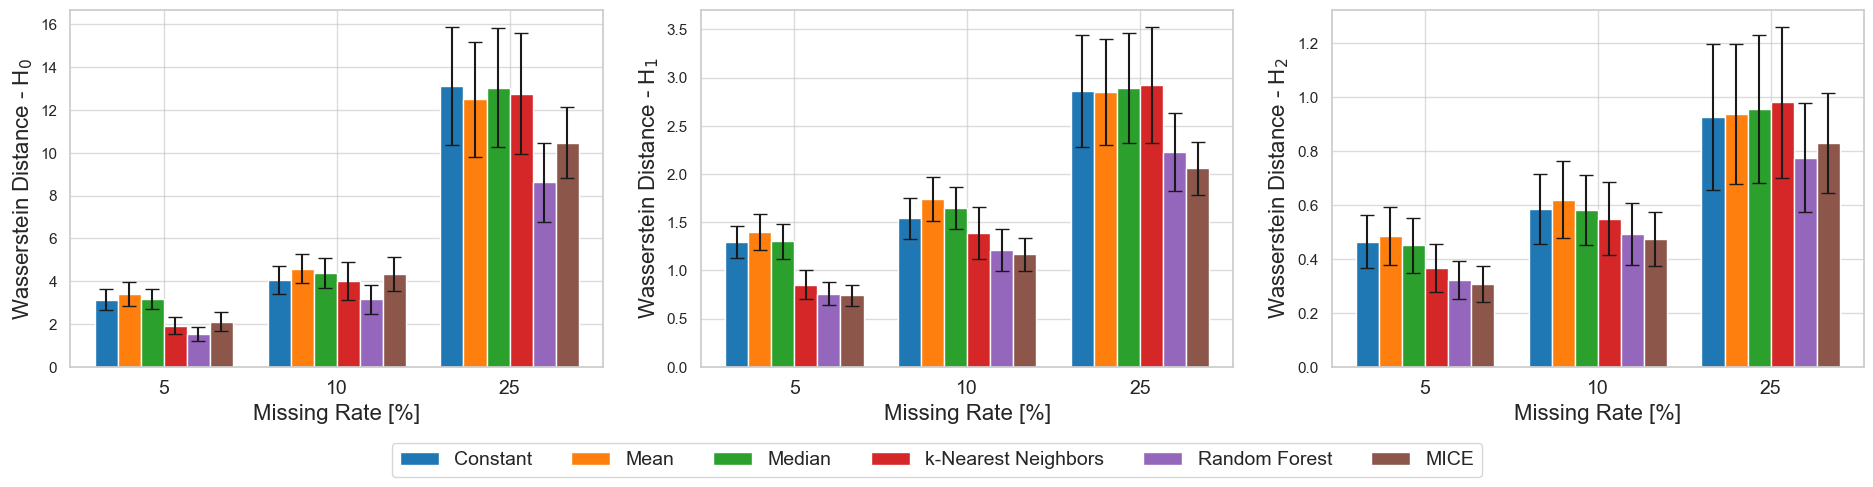

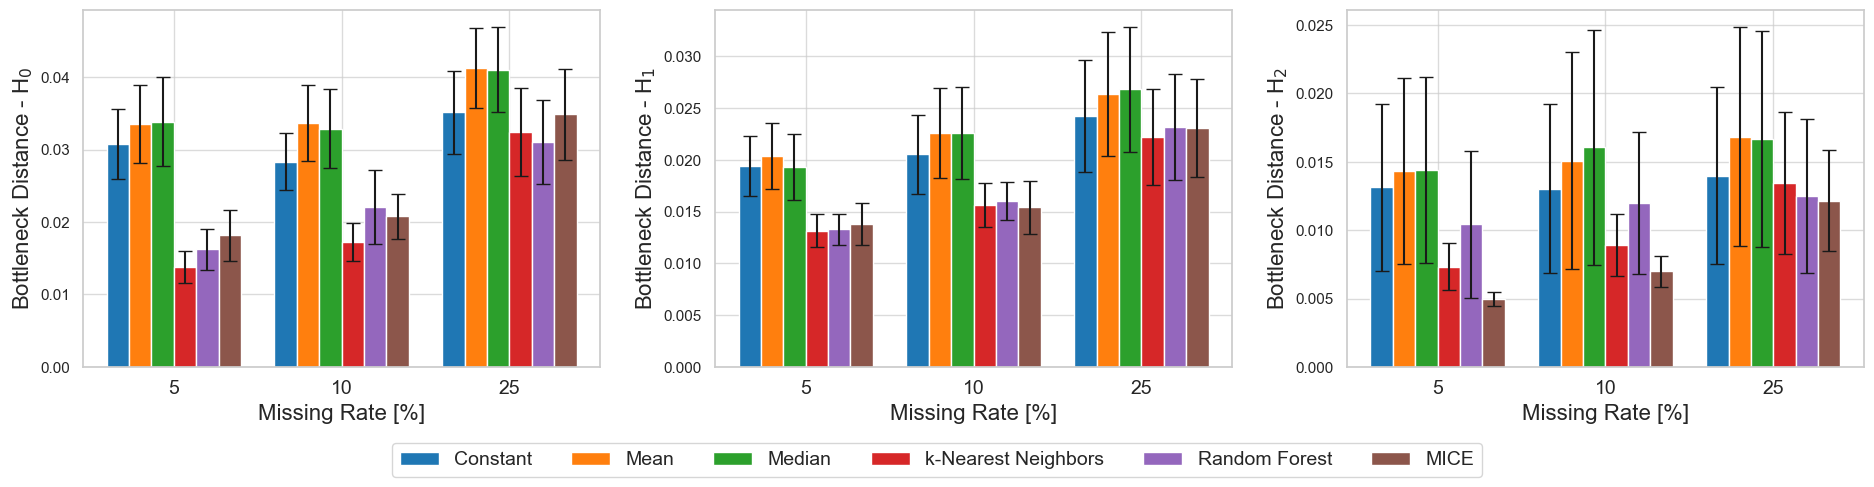

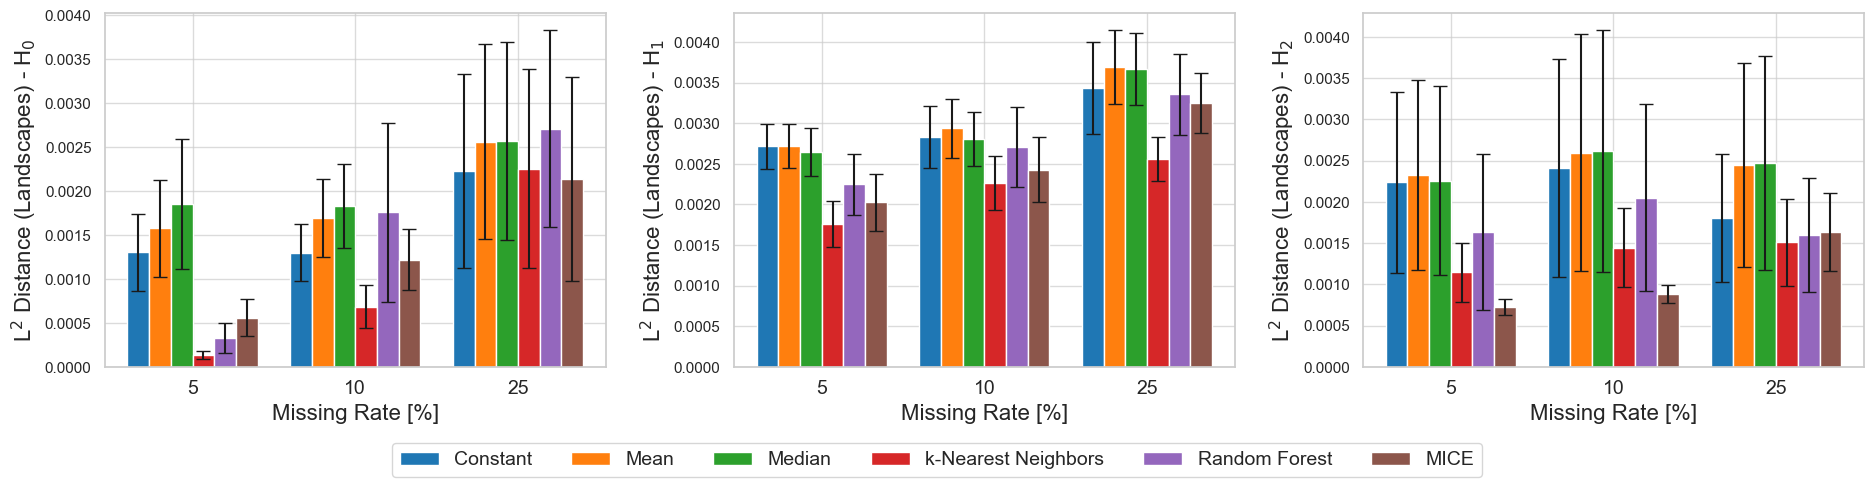

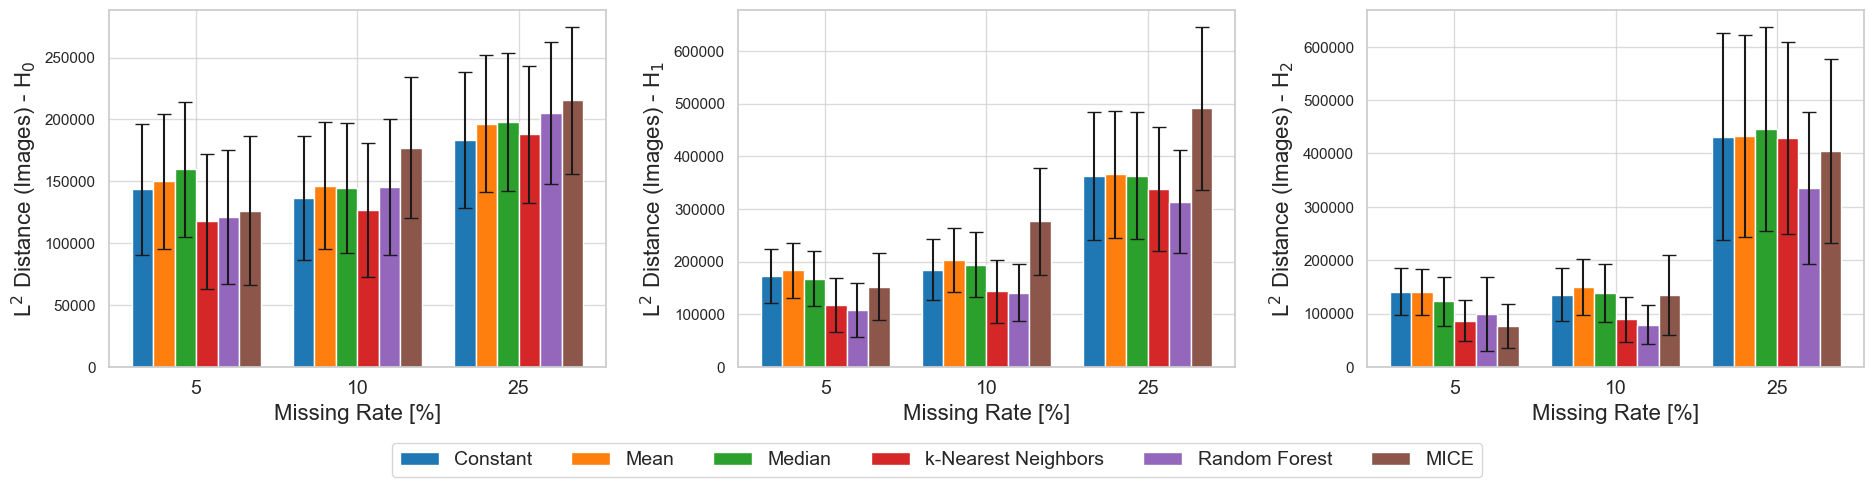

In [8]:
df = group_results(
    csv=IMPACT_IMPUTATION,
    group=[DATASET, IMPUTATION_METHOD, DIMENSION, MISSING_RATE],
    metrics=COLLECTIONS[TDA_METRIC]
)

for m, metric in enumerate(COLLECTIONS[TDA_METRIC]):
    fig, axes = setup_figure(
        rows=1,
        cols=len(DIMENSIONS)
    )
    axes = axes.flatten()

    for i, dim in enumerate(DIMENSIONS):
        ax = axes[i]
        df_stats, x, width = boxplot_stats(
            df=df, 
            filter=df[DIMENSION] == dim, 
            group=[MISSING_RATE, IMPUTATION_METHOD], 
            metric=metric,
            steps=COLLECTIONS[MISSING_RATE], 
            ticks=COLLECTIONS[IMPUTATION_METHOD]
        )

        for j, imp in enumerate(COLLECTIONS[IMPUTATION_METHOD]):
            mean, sem = compute_mean_sem(
                type=IMPUTATION_METHOD,
                data=df_stats,
                group=MISSING_RATE,
                filter=df_stats[IMPUTATION_METHOD] == imp
            )
            plot_data(
                type=IMPUTATION_METHOD,
                ax=ax, mean=mean, sem=sem,
                label=LABEL[imp],
                color=plt.get_cmap(COLOR_MAP[IMPUTATION_METHOD])(COLLECTIONS[IMPUTATION_METHOD].index(imp)),
                x=x+j*width,
                width=width
            )

        format_axes(
            type=IMPUTATION_METHOD, 
            ax=ax,
            x_label=LABEL[MISSING_RATE],
            y_label=f'{LABEL[metric]} - {LABEL[dim]}',
            ticks=x + width*(len(COLLECTIONS[IMPUTATION_METHOD])-1)/2,
            tick_labels=COLLECTIONS[MISSING_RATE]
        )

    legend(
        axes=axes, 
        fig=fig, 
        cols=len(COLLECTIONS[IMPUTATION_METHOD]),
        bbox=(0.5, -0.1)
    )
    plot(fig, f'../figures/results/imp_{topological_error[m]}.svg')

## Imputation Method - Dataset Type

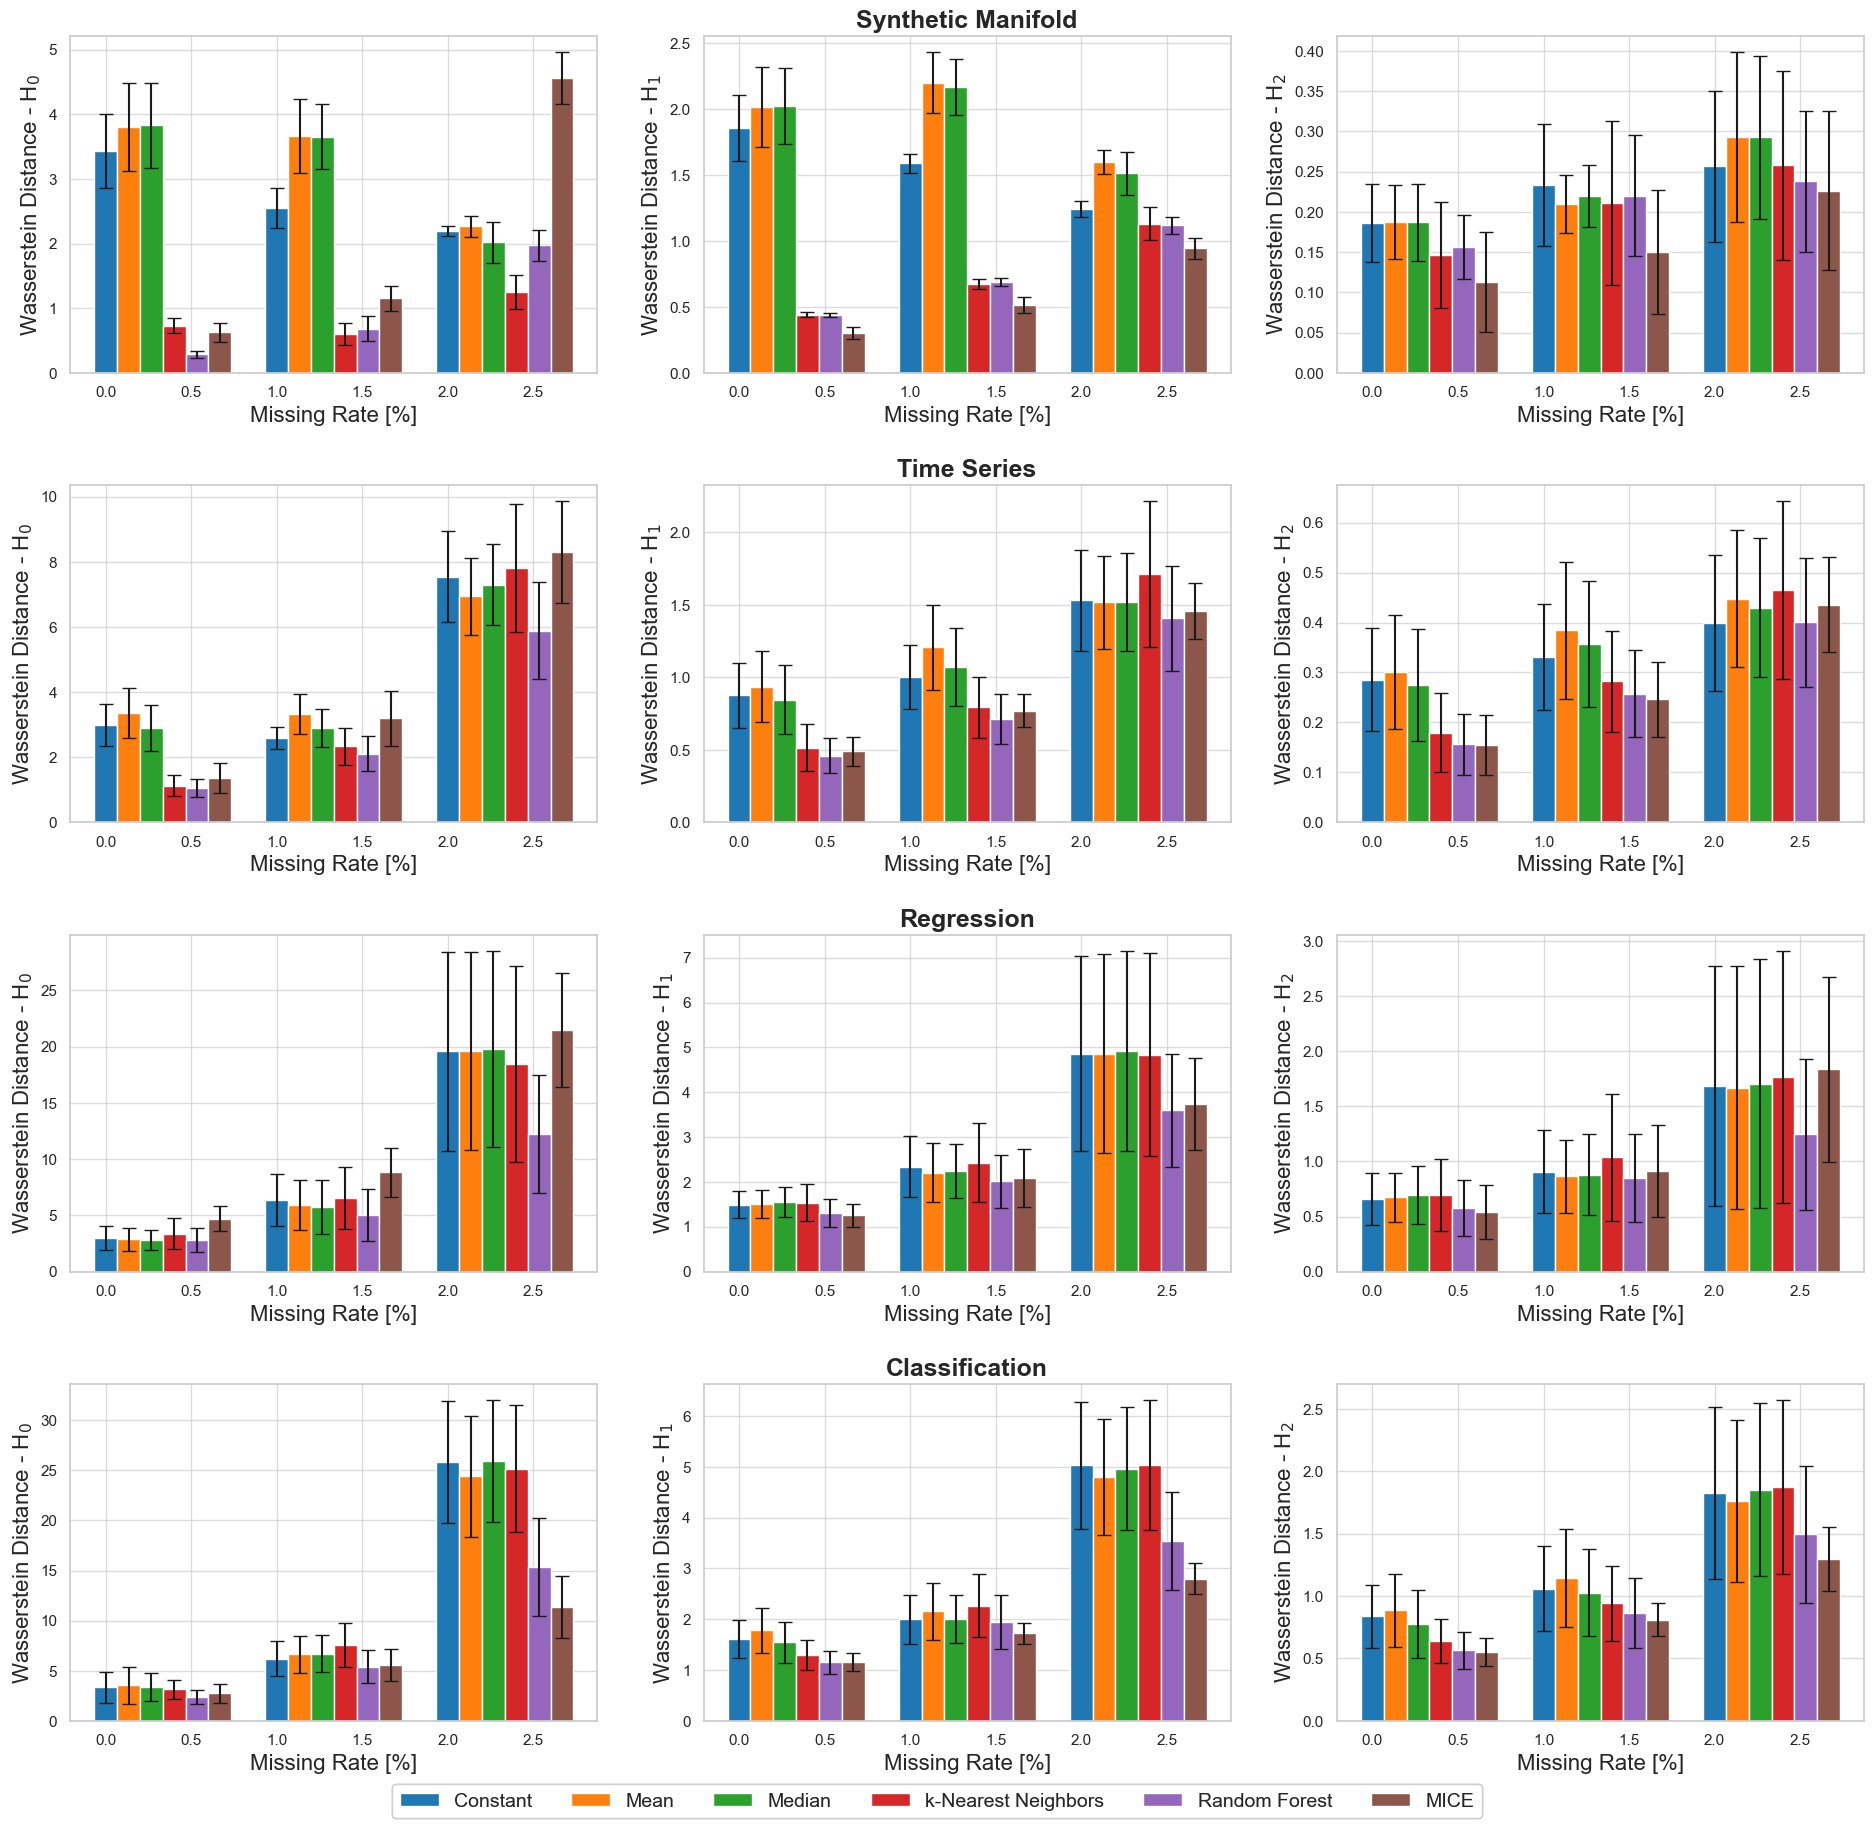

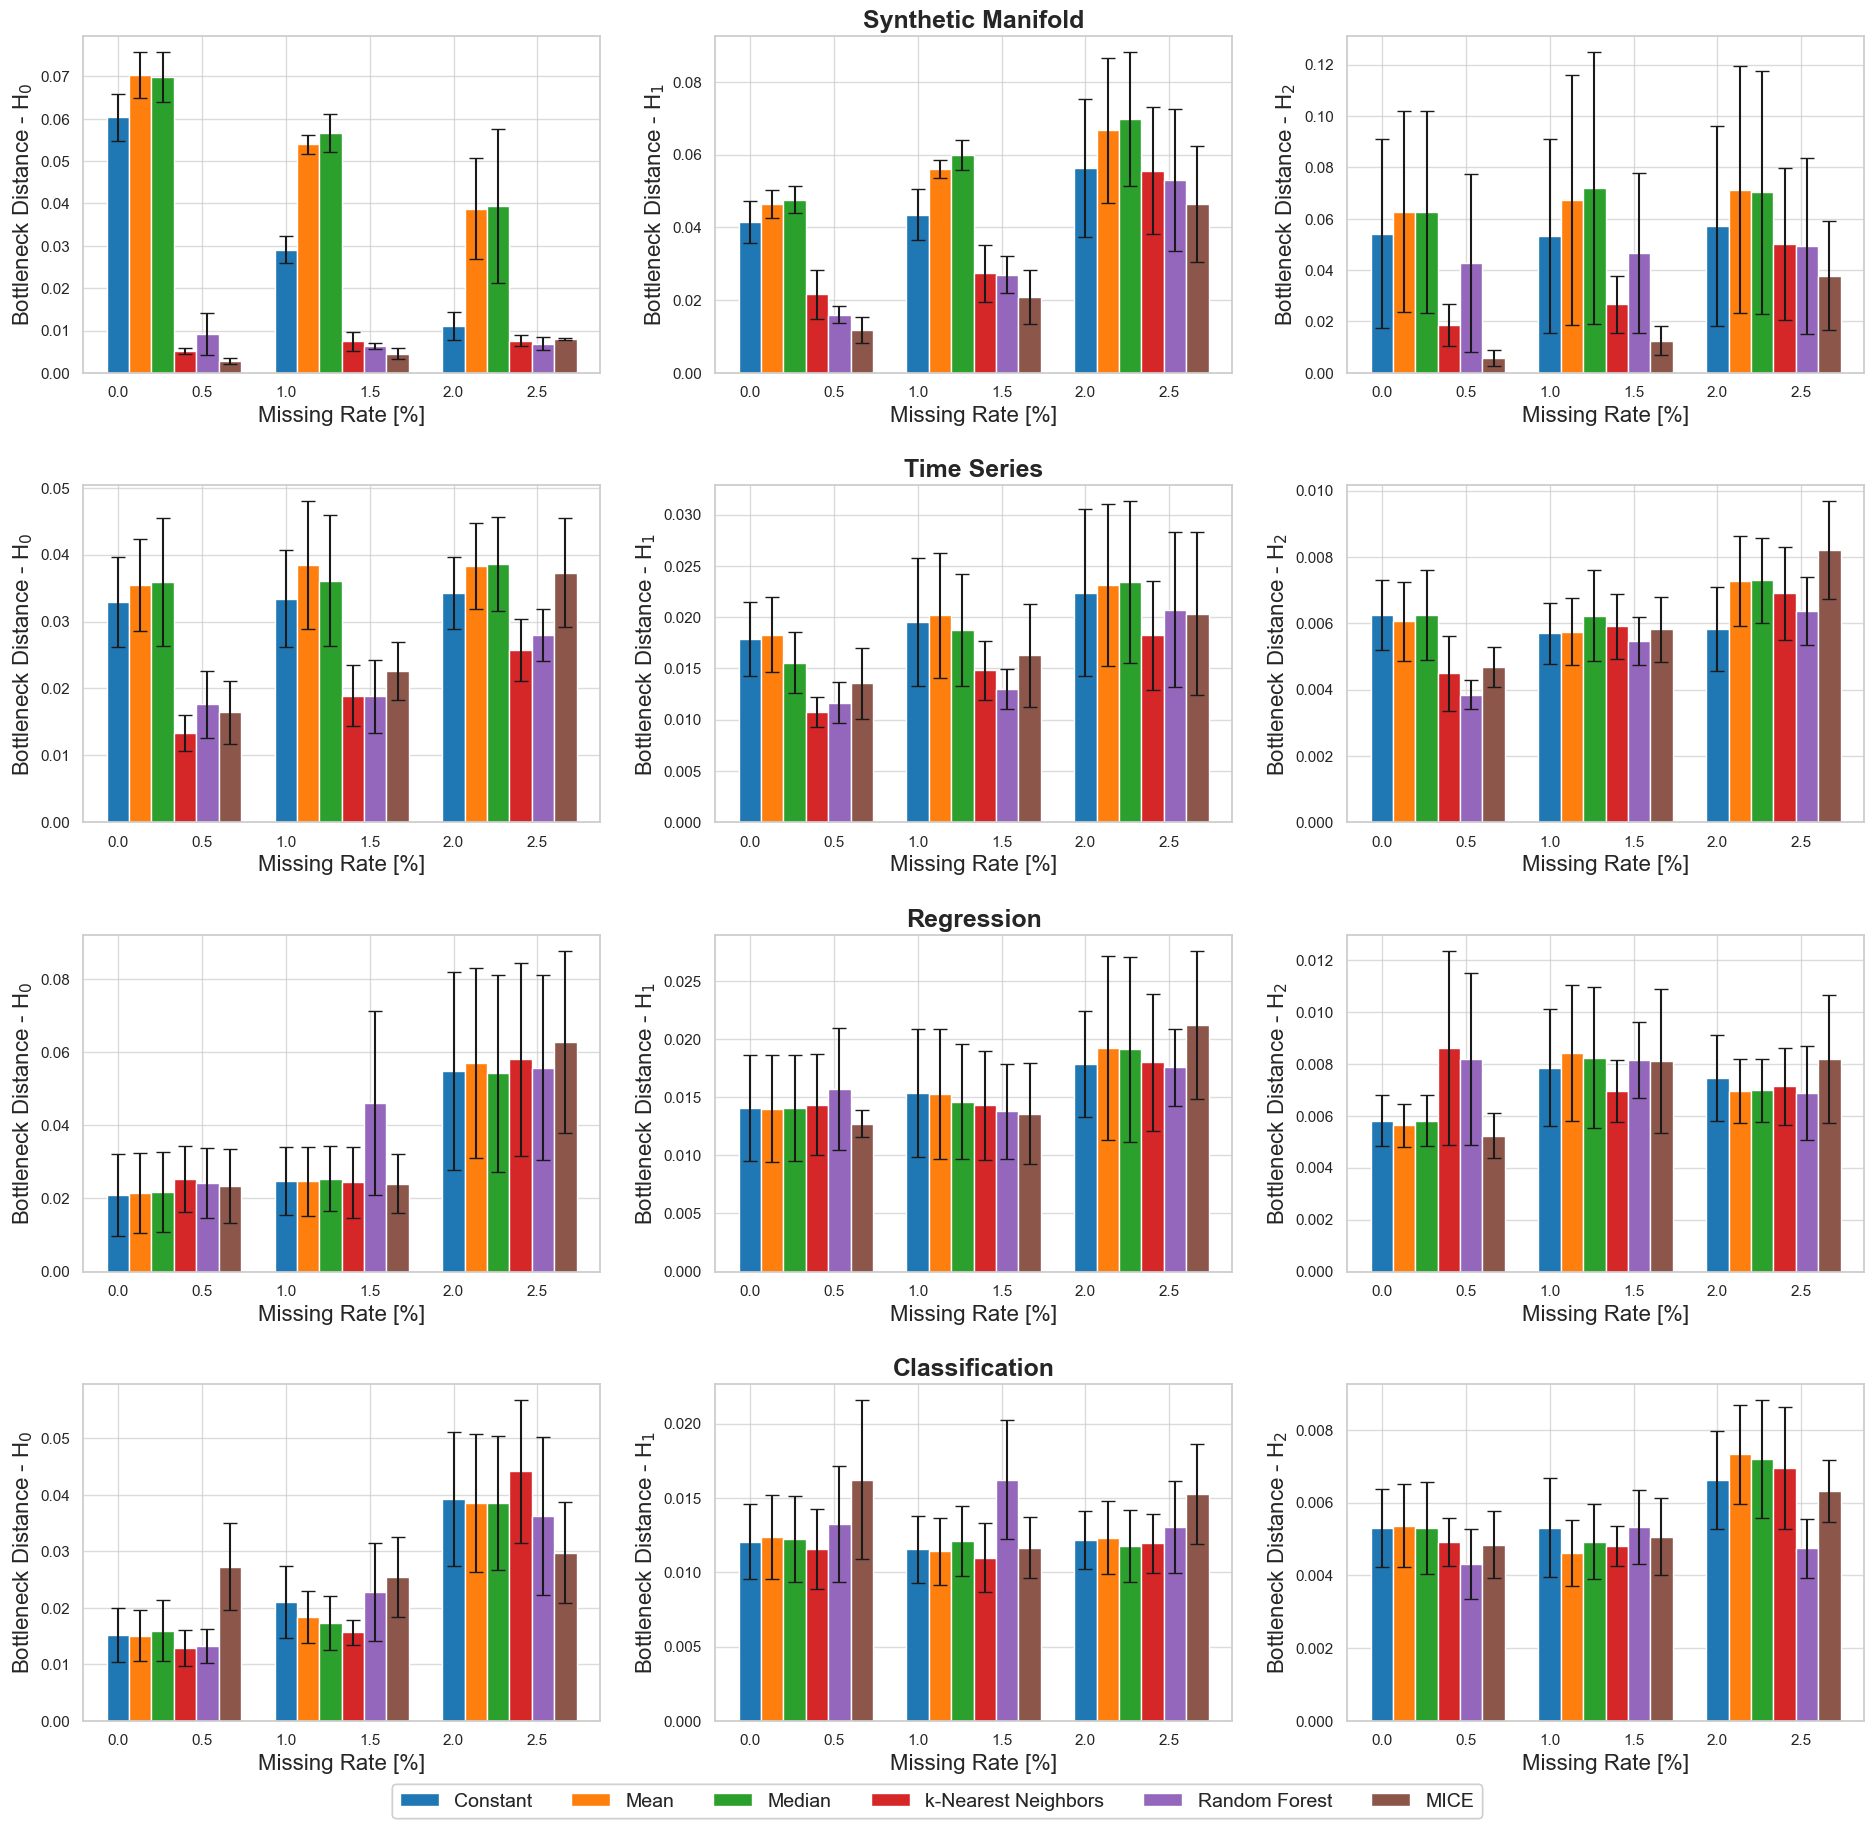

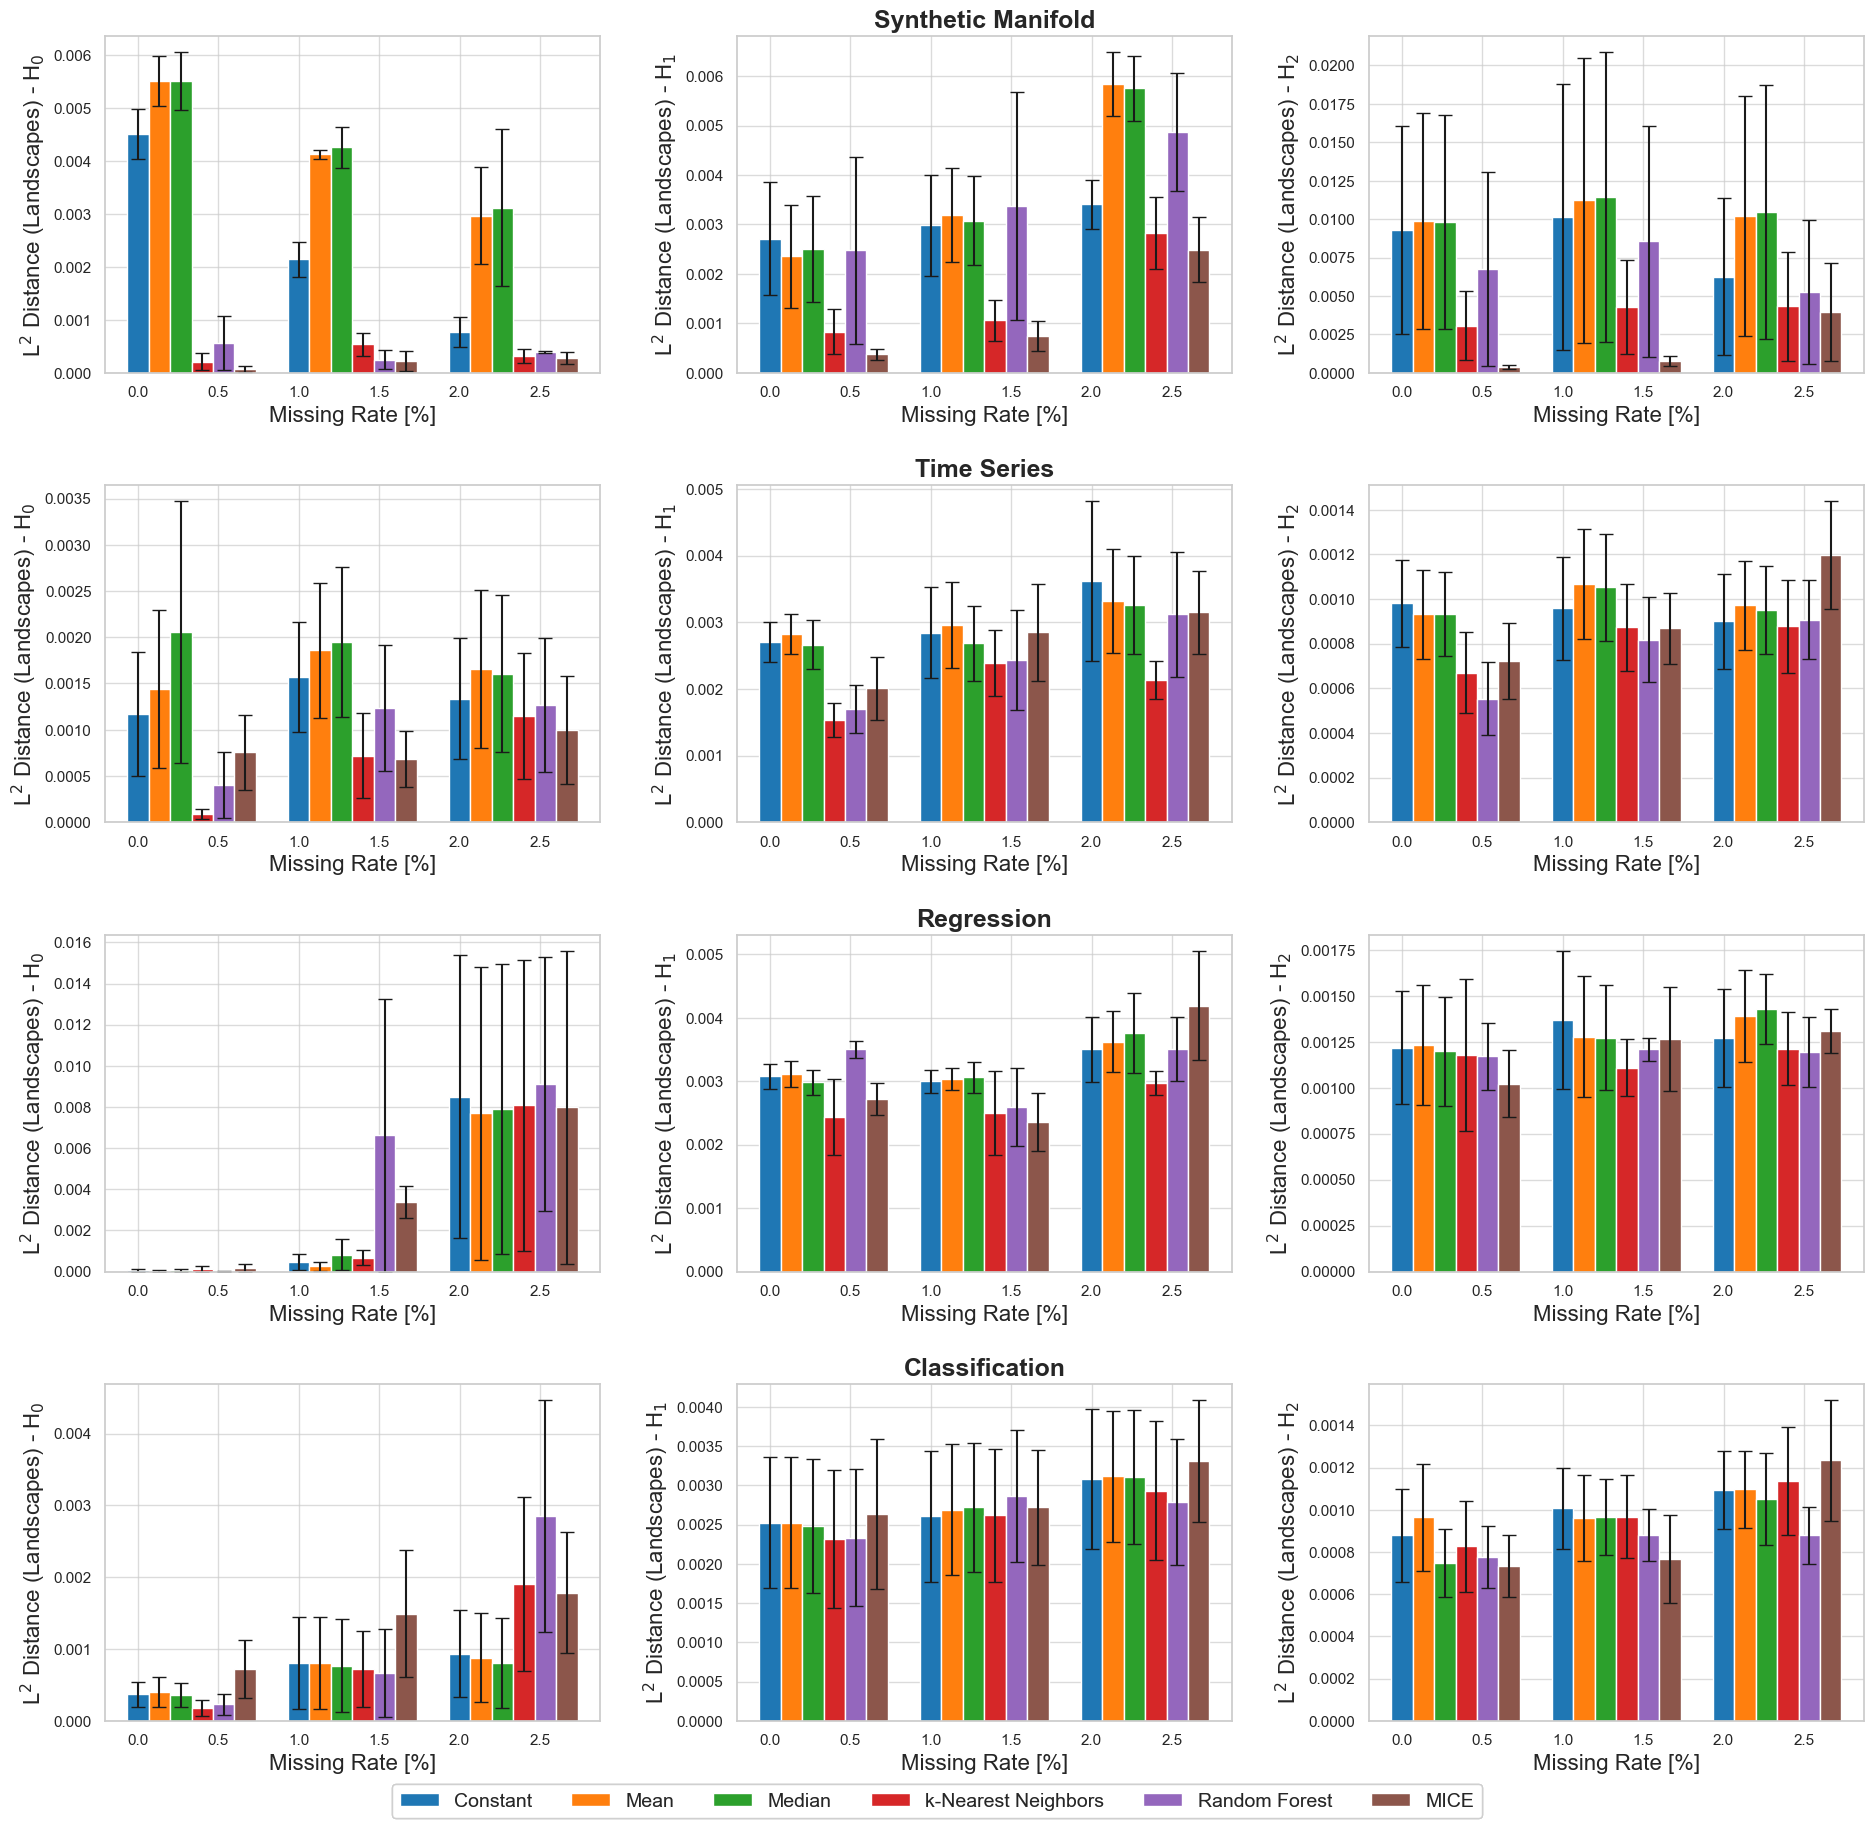

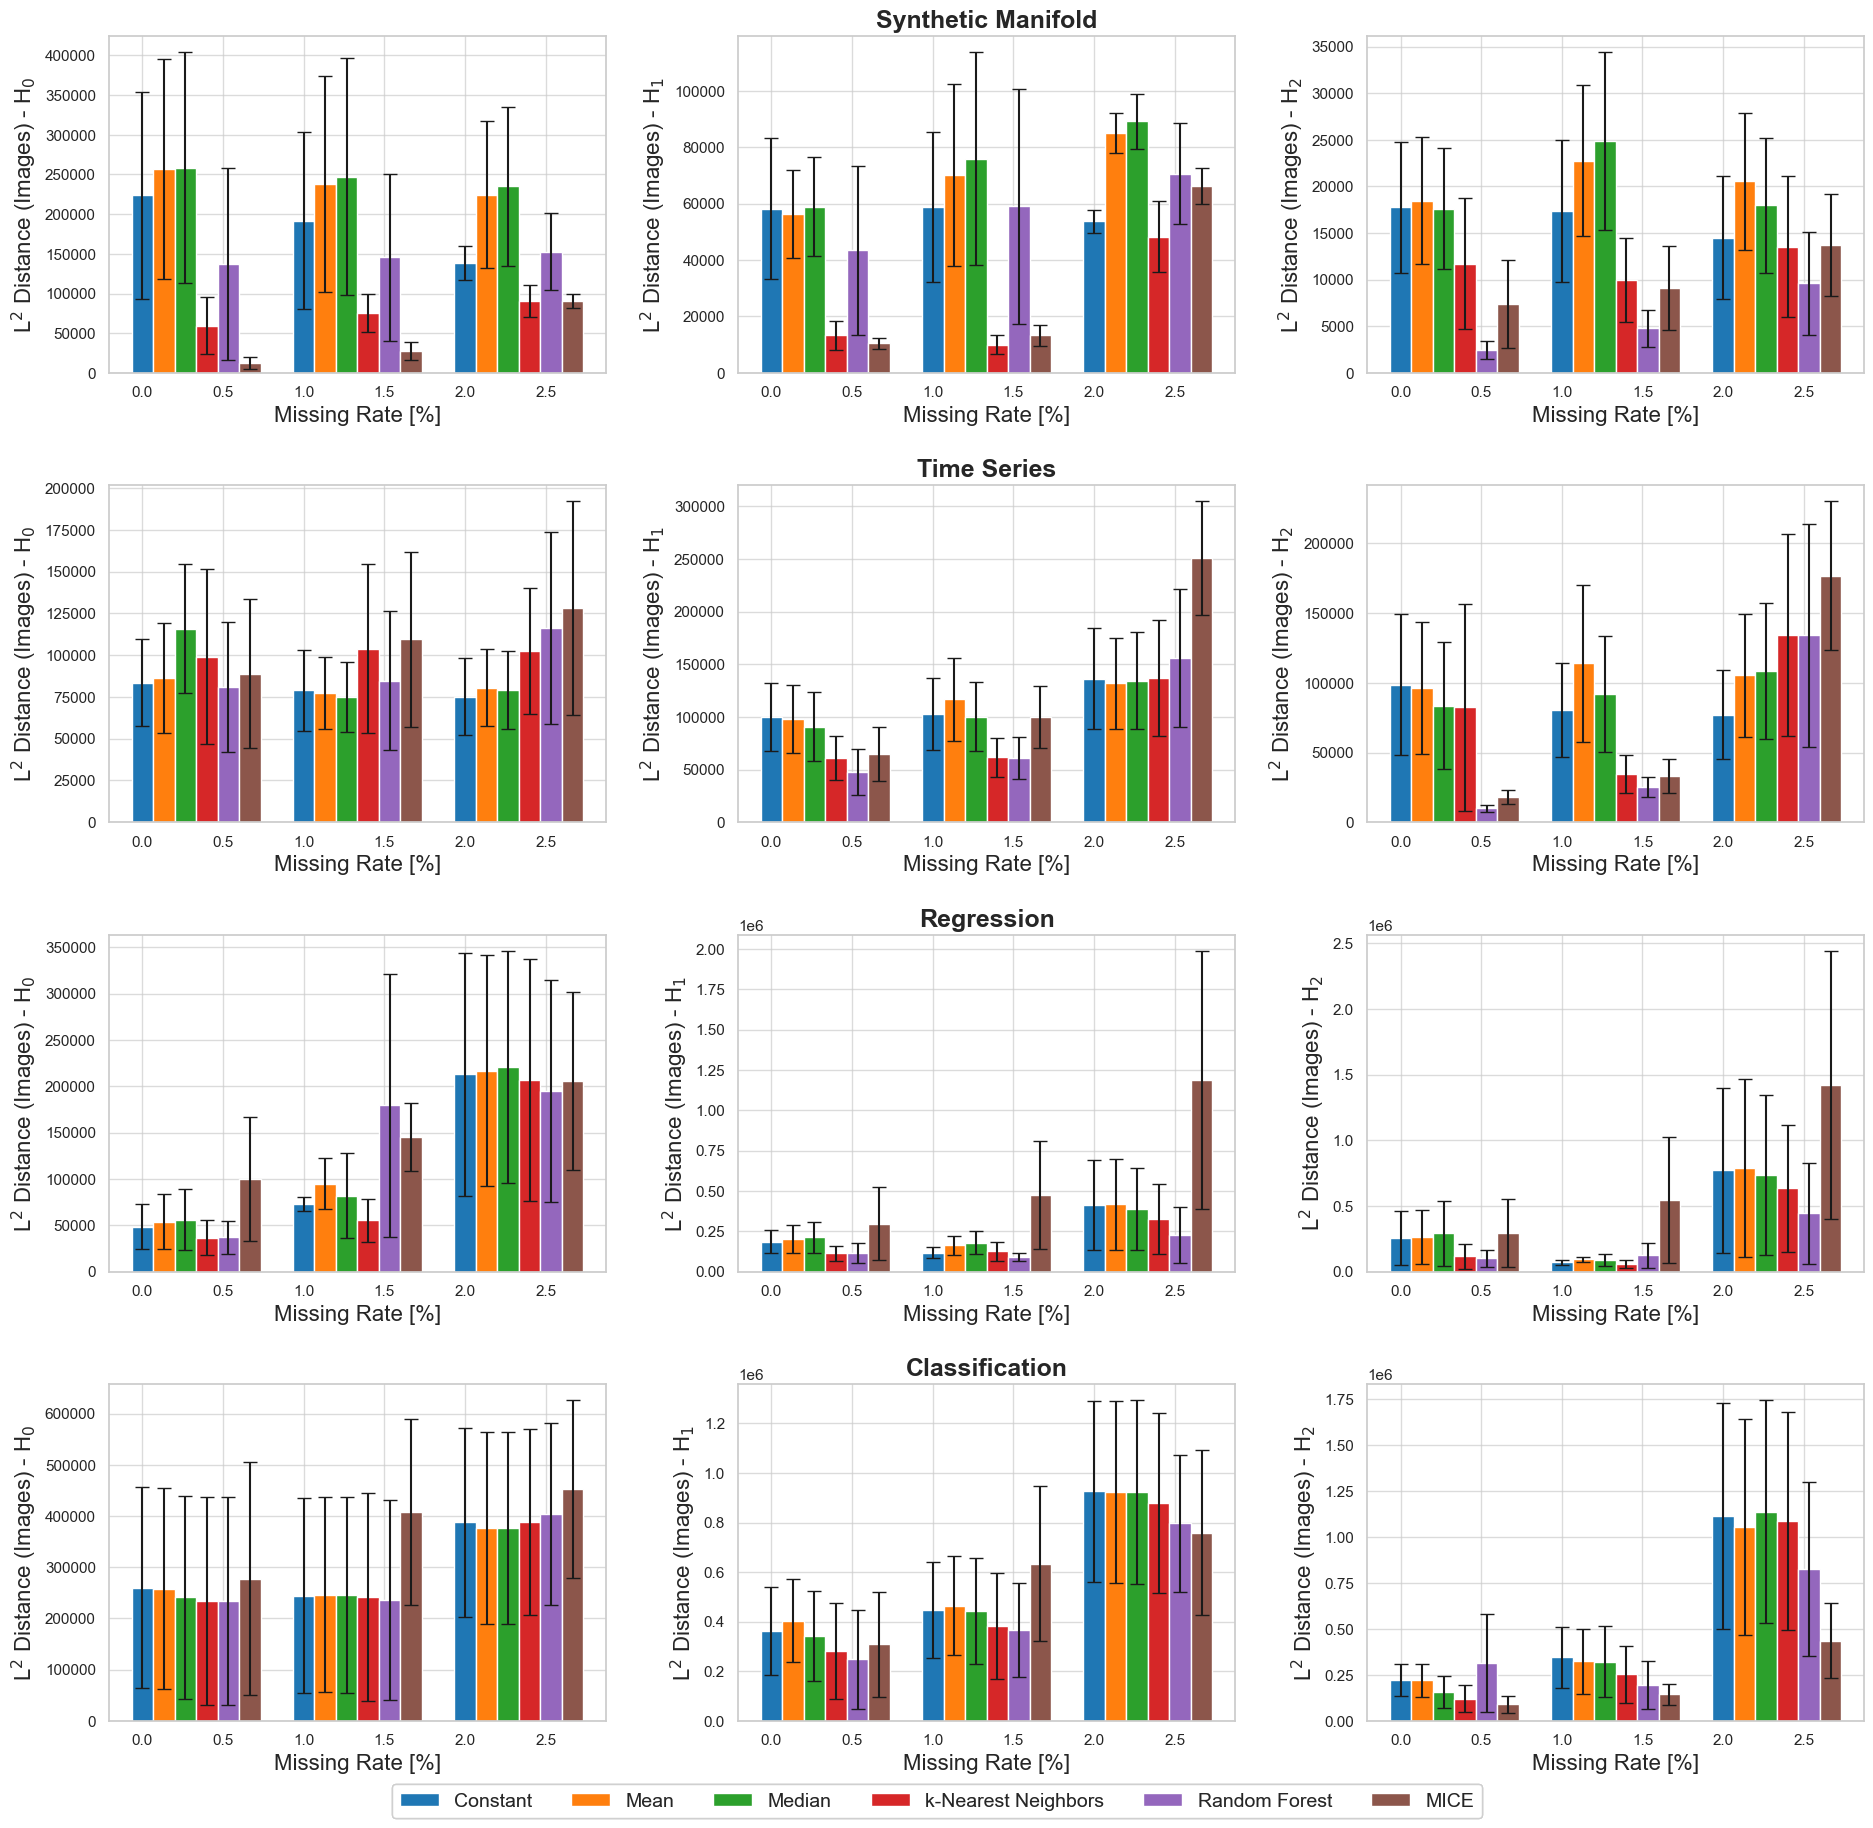

In [9]:
df = group_results(
    csv=IMPACT_IMPUTATION,
    group=[DATASET, IMPUTATION_METHOD, DIMENSION, MISSING_RATE],
    metrics=COLLECTIONS[TDA_METRIC]
)

for m, metric in enumerate(COLLECTIONS[TDA_METRIC]):
    fig, axes = setup_figure(
        rows=len(COLLECTIONS[DATASET_TYPE]),
        cols=len(DIMENSIONS)
    )

    for i, dataset_type in enumerate(COLLECTIONS[DATASET_TYPE]):
        df_filtered = df[df[DATASET].isin(COLLECTIONS[dataset_type])].copy()

        for dim in DIMENSIONS:
            ax = axes[i][dim]
            df_stats, x, width = boxplot_stats(
                df=df_filtered, 
                filter=df_filtered[DIMENSION] == dim, 
                group=[MISSING_RATE, IMPUTATION_METHOD], 
                metric=metric,
                steps=COLLECTIONS[MISSING_RATE], 
                ticks=COLLECTIONS[IMPUTATION_METHOD]
            )

            for j, imp in enumerate(COLLECTIONS[IMPUTATION_METHOD]):
                mean, sem = compute_mean_sem(
                    type=IMPUTATION_METHOD,
                    data=df_stats,
                    group=MISSING_RATE,
                    filter=df_stats[IMPUTATION_METHOD] == imp
                )

                format_axes(
                    type=MISSINGNESS_TYPE, 
                    ax=ax,
                    x_label=LABEL[MISSING_RATE],
                    y_label=f'{LABEL[metric]} - {LABEL[dim]}',
                    ticks=x + width*(len(COLLECTIONS[IMPUTATION_METHOD])-1)/2,
                    tick_labels=COLLECTIONS[MISSING_RATE],
                    title=dim==1,
                    title_label=LABEL[dataset_type]
                )
                plot_data(
                    type=IMPUTATION_METHOD,
                    ax=ax, mean=mean, sem=sem,
                    label=LABEL[imp],
                    color=plt.get_cmap(COLOR_MAP[IMPUTATION_METHOD])(COLLECTIONS[IMPUTATION_METHOD].index(imp)),
                    x=x+j*width,
                    width=width
                )

        legend(
            axes=axes[0],
            fig=fig, 
            cols=len(COLLECTIONS[IMPUTATION_METHOD]),
            bbox=(0.5, -0.02)
        )

    plot(fig, f'../figures/appendix/imp_dataset_{topological_error[m]}.svg')

## Imputation Method - Comparison Metrics

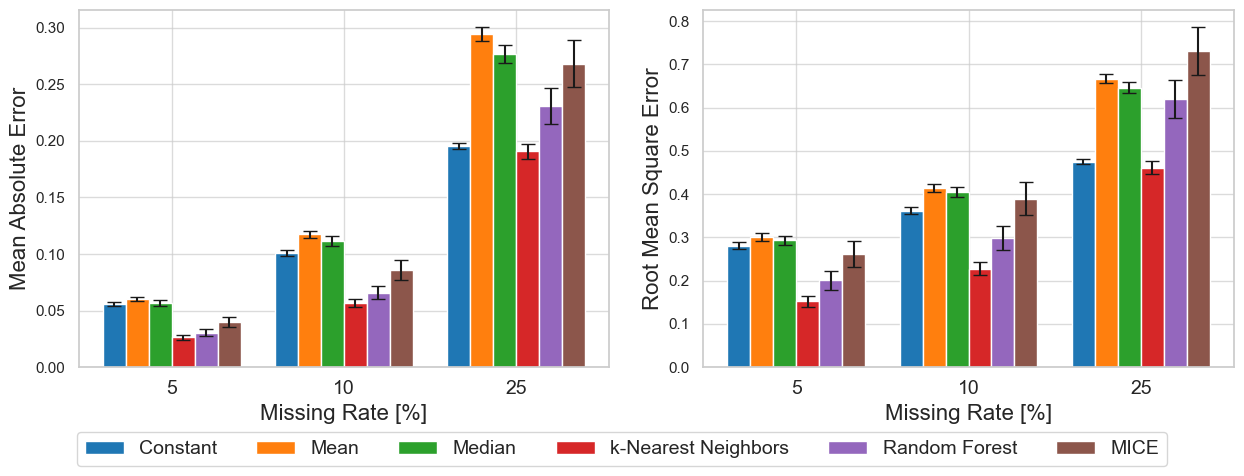

In [10]:
df = group_results(
    csv=COMPARISON_METRICS,
    group=[DATASET, IMPUTATION_METHOD, MISSING_RATE],
    metrics=COLLECTIONS[METRIC]
)
df = df[df[MISSING_RATE].isin(COLLECTIONS[MISSING_RATE])]

fig, axes = setup_figure(
    rows=1,
    cols=len(COLLECTIONS[METRIC])
)
axes = axes.flatten()
for i, metric in enumerate(COLLECTIONS[METRIC]):
    ax = axes[i]
    df_stats, x, width = boxplot_stats(
        df=df, 
        group=[MISSING_RATE, IMPUTATION_METHOD], 
        metric=metric,
        steps=COLLECTIONS[MISSING_RATE], 
        ticks=COLLECTIONS[IMPUTATION_METHOD]
    )

    for j, imp in enumerate(COLLECTIONS[IMPUTATION_METHOD]):
        mean, sem = compute_mean_sem(
            type=IMPUTATION_METHOD,
            data=df_stats,
            group=MISSING_RATE,
            filter=df_stats[IMPUTATION_METHOD] == imp
        )
        plot_data(
            type=IMPUTATION_METHOD,
            ax=ax, mean=mean, sem=sem,
            label=LABEL[imp],
            color=plt.get_cmap(COLOR_MAP[IMPUTATION_METHOD])(COLLECTIONS[IMPUTATION_METHOD].index(imp)),
            x=x+j*width,
            width=width
        )

    format_axes(
        type=IMPUTATION_METHOD, 
        ax=ax,
        x_label=LABEL[MISSING_RATE],
        y_label=f'{LABEL[metric]}',
        ticks=x + width*(len(COLLECTIONS[IMPUTATION_METHOD])-1)/2,
        tick_labels=COLLECTIONS[MISSING_RATE]
    )

legend(
    axes=axes, 
    fig=fig, 
    cols=len(COLLECTIONS[IMPUTATION_METHOD]),
    bbox=(0.5, -0.075)
)
plot(fig, '../figures/analysis/imp_raw.svg')

## Imputation Method - Comparison Metrics - Dataset Type

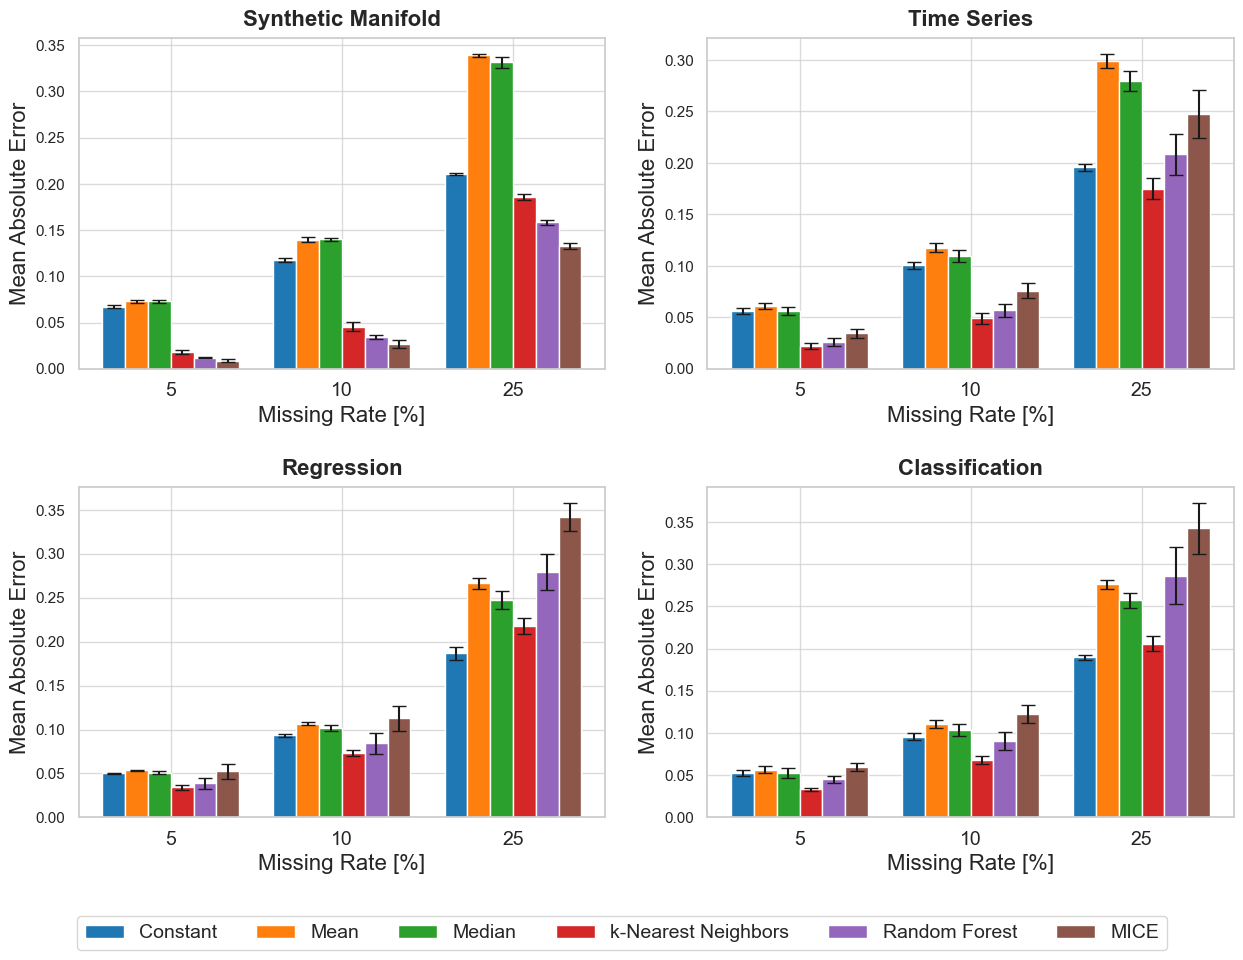

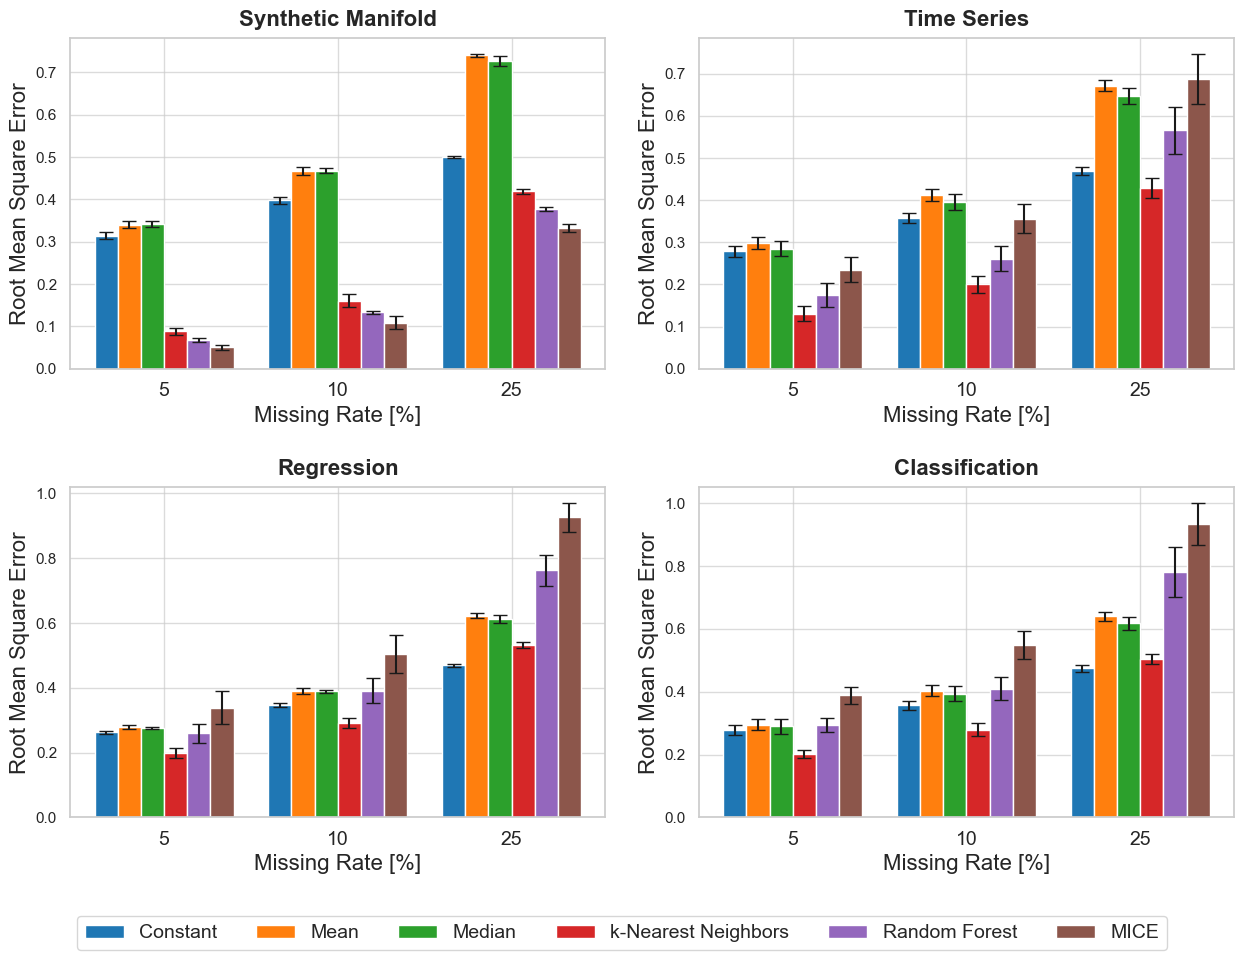

In [11]:
df = group_results(
    csv=COMPARISON_METRICS,
    group=[DATASET, IMPUTATION_METHOD, MISSING_RATE],
    metrics=COLLECTIONS[METRIC]
)
df = df[df[MISSING_RATE].isin(COLLECTIONS[MISSING_RATE])]

for m, metric in enumerate(COLLECTIONS[METRIC]):
    fig, axes = setup_figure(
        cells=len(COLLECTIONS[DATASET_TYPE])
    )
    axes = axes.flatten()
    for i, dataset_type in enumerate(COLLECTIONS[DATASET_TYPE]):
        df_filtered = df[df[DATASET].isin(COLLECTIONS[dataset_type])].copy()
        ax = axes[i]
        df_stats, x, width = boxplot_stats(
            df=df_filtered, 
            group=[MISSING_RATE, IMPUTATION_METHOD], 
            metric=metric,
            steps=COLLECTIONS[MISSING_RATE], 
            ticks=COLLECTIONS[IMPUTATION_METHOD]
        )

        for j, imp in enumerate(COLLECTIONS[IMPUTATION_METHOD]):
            mean, sem = compute_mean_sem(
                type=IMPUTATION_METHOD,
                data=df_stats,
                group=MISSING_RATE,
                filter=df_stats[IMPUTATION_METHOD] == imp
            )
            plot_data(
                type=IMPUTATION_METHOD,
                ax=ax, mean=mean, sem=sem,
                label=LABEL[imp],
                color=plt.get_cmap(COLOR_MAP[IMPUTATION_METHOD])(COLLECTIONS[IMPUTATION_METHOD].index(imp)),
                x=x+j*width,
                width=width
            )

        format_axes(
            type=IMPUTATION_METHOD, 
            ax=ax,
            x_label=LABEL[MISSING_RATE],
            y_label=LABEL[metric],
            ticks=x + width*(len(COLLECTIONS[IMPUTATION_METHOD])-1)/2,
            tick_labels=COLLECTIONS[MISSING_RATE]
        )
        ax.text(0.5, 1.025, LABEL[dataset_type], transform=ax.transAxes, ha='center', va='bottom', fontsize=16, weight='bold')

    legend(
        axes=axes, 
        fig=fig, 
        cols=len(COLLECTIONS[IMPUTATION_METHOD]),
        bbox=(0.5, -0.075)
    )
    plot(fig, f'../figures/appendix/imp_raw_{imputation_error[m]}.svg')

## Filtration Techniques - General

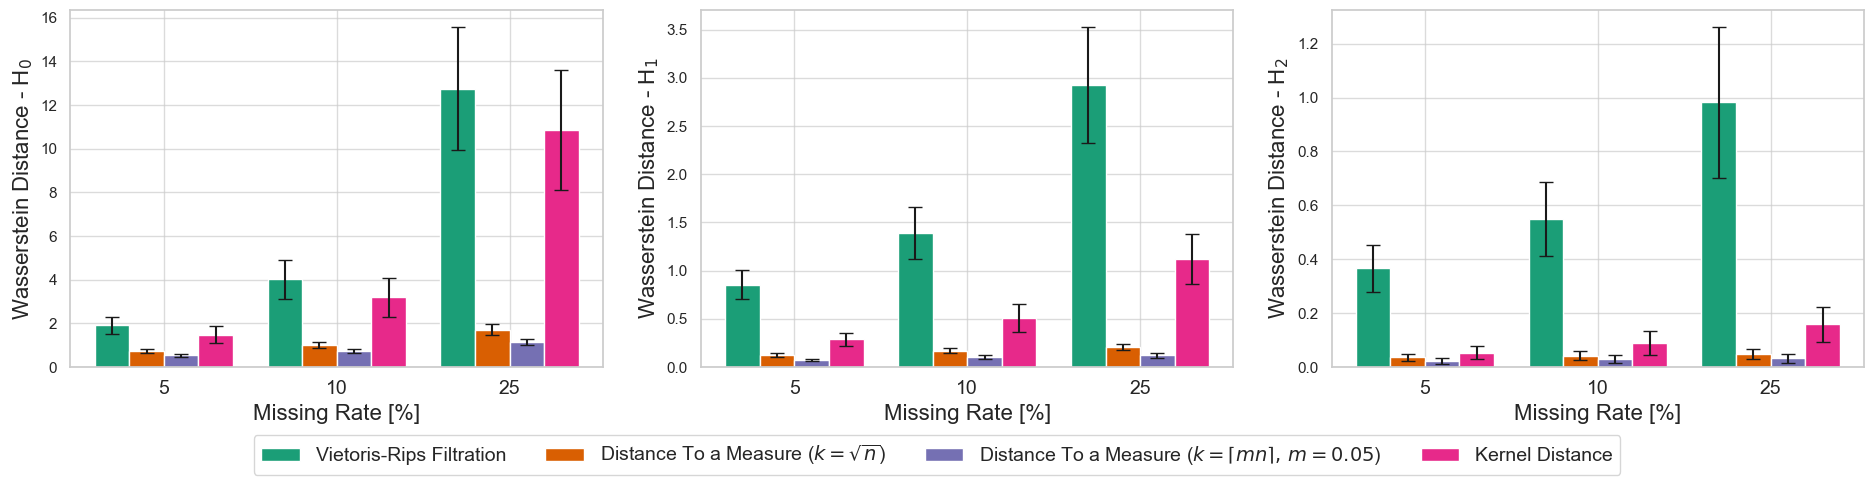

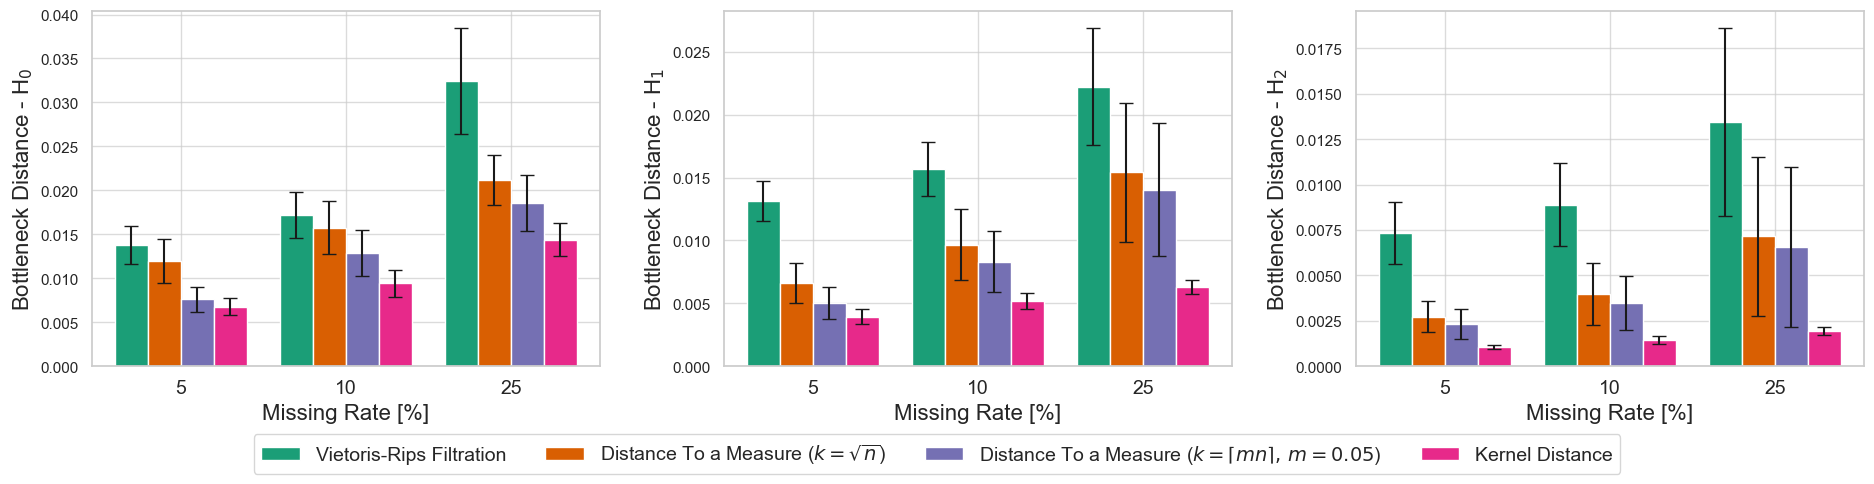

In [12]:
df = group_results(
    csv=IMPACT_TDA,
    group=[DATASET, TDA_METHOD, DIMENSION, MISSING_RATE],
    metrics=COLLECTIONS[TDA_METRIC_SHORT]
)

for m, metric in enumerate(COLLECTIONS[TDA_METRIC_SHORT]):
    fig, axes = setup_figure(
        rows=1,
        cols=len(DIMENSIONS)
    )
    axes = axes.flatten()

    for dim in DIMENSIONS:
        ax = axes[dim]
        df_stats, x, width = boxplot_stats(
            df=df, 
            filter=df[DIMENSION] == dim, 
            group=[MISSING_RATE, TDA_METHOD], 
            metric=metric,
            steps=COLLECTIONS[MISSING_RATE], 
            ticks=COLLECTIONS[TDA_METHOD]
        )

        for j, tda in enumerate(COLLECTIONS[TDA_METHOD]):
            mean, sem = compute_mean_sem(
                type=TDA_METHOD,
                data=df_stats,
                group=MISSING_RATE,
                filter=df_stats[TDA_METHOD] == tda
            )
            plot_data(
                type=TDA_METHOD,
                ax=ax, mean=mean, sem=sem,
                label=LABEL[tda],
                color=plt.get_cmap(COLOR_MAP[TDA_METHOD])(COLLECTIONS[TDA_METHOD].index(tda)),
                x=x+j*width,
                width=width
            )

        format_axes(
            type=TDA_METHOD, 
            ax=ax,
            x_label=LABEL[MISSING_RATE],
            y_label=f'{LABEL[metric]} - {LABEL[dim]}',
            ticks=x + width*(len(COLLECTIONS[TDA_METHOD])-1)/2,
            tick_labels=COLLECTIONS[MISSING_RATE]
        )

    legend(
        axes=axes, 
        fig=fig, 
        cols=len(COLLECTIONS[TDA_METHOD]),
        bbox=(0.5, -0.095)
    )
    plot(fig, f'../figures/results/tda_{topological_error[m]}.svg')

## Filtration Techniques - Dataset Type

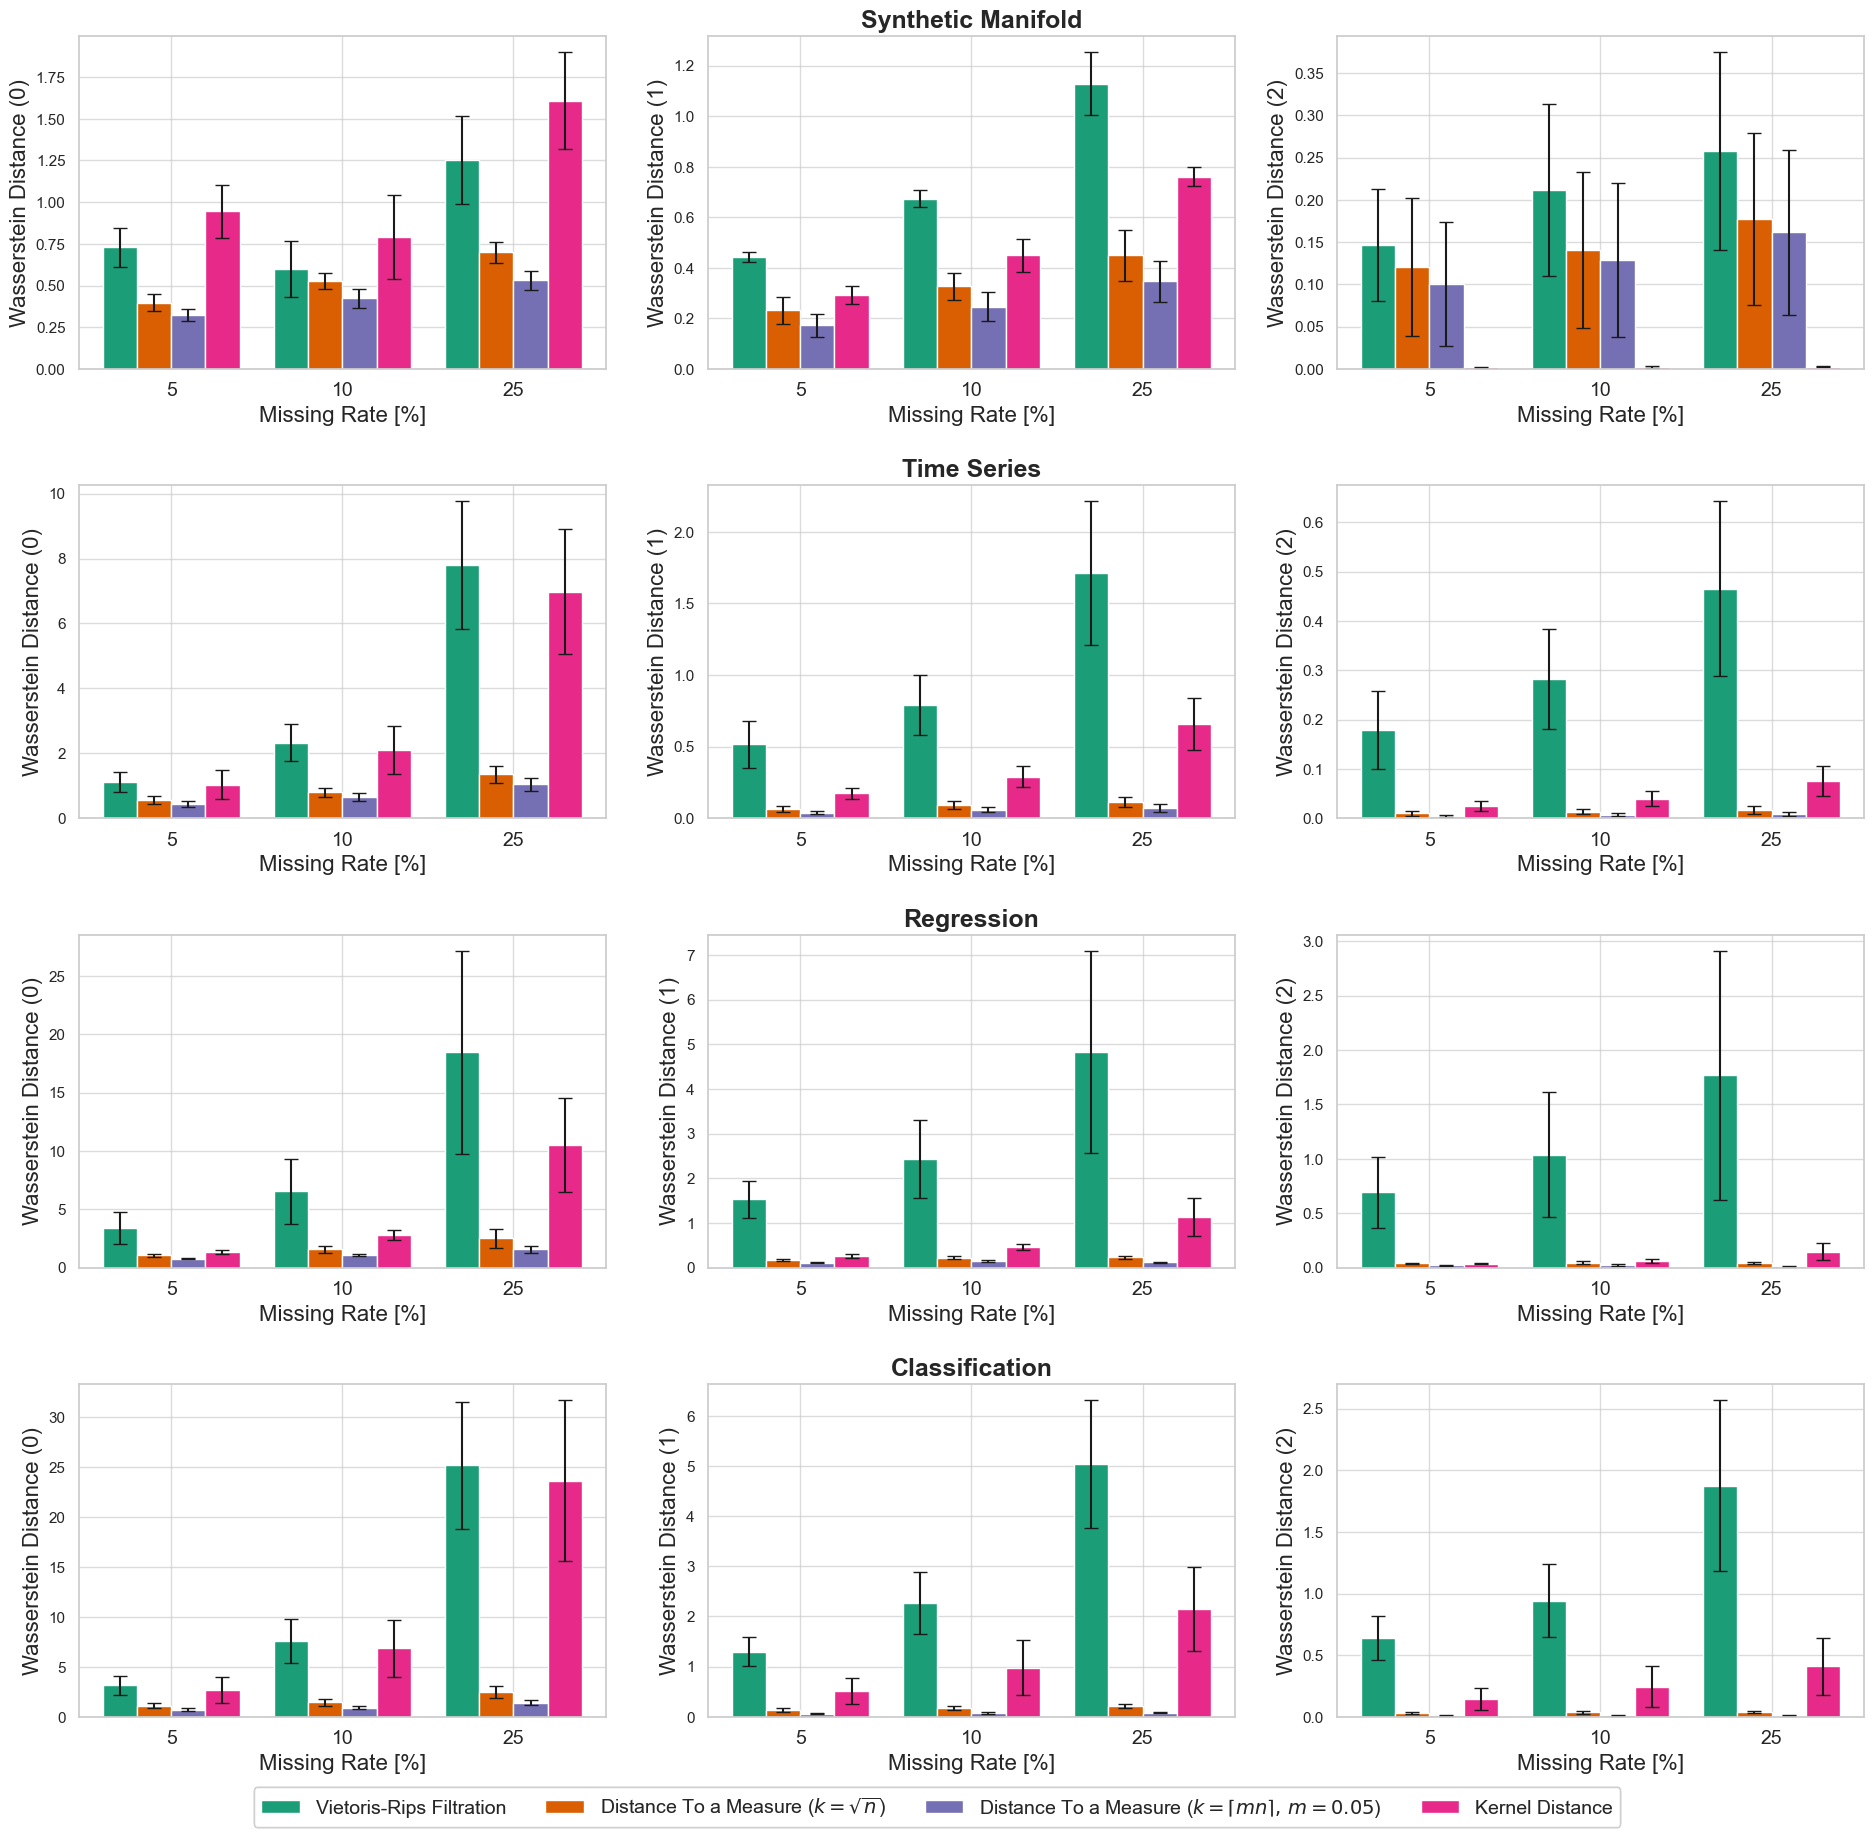

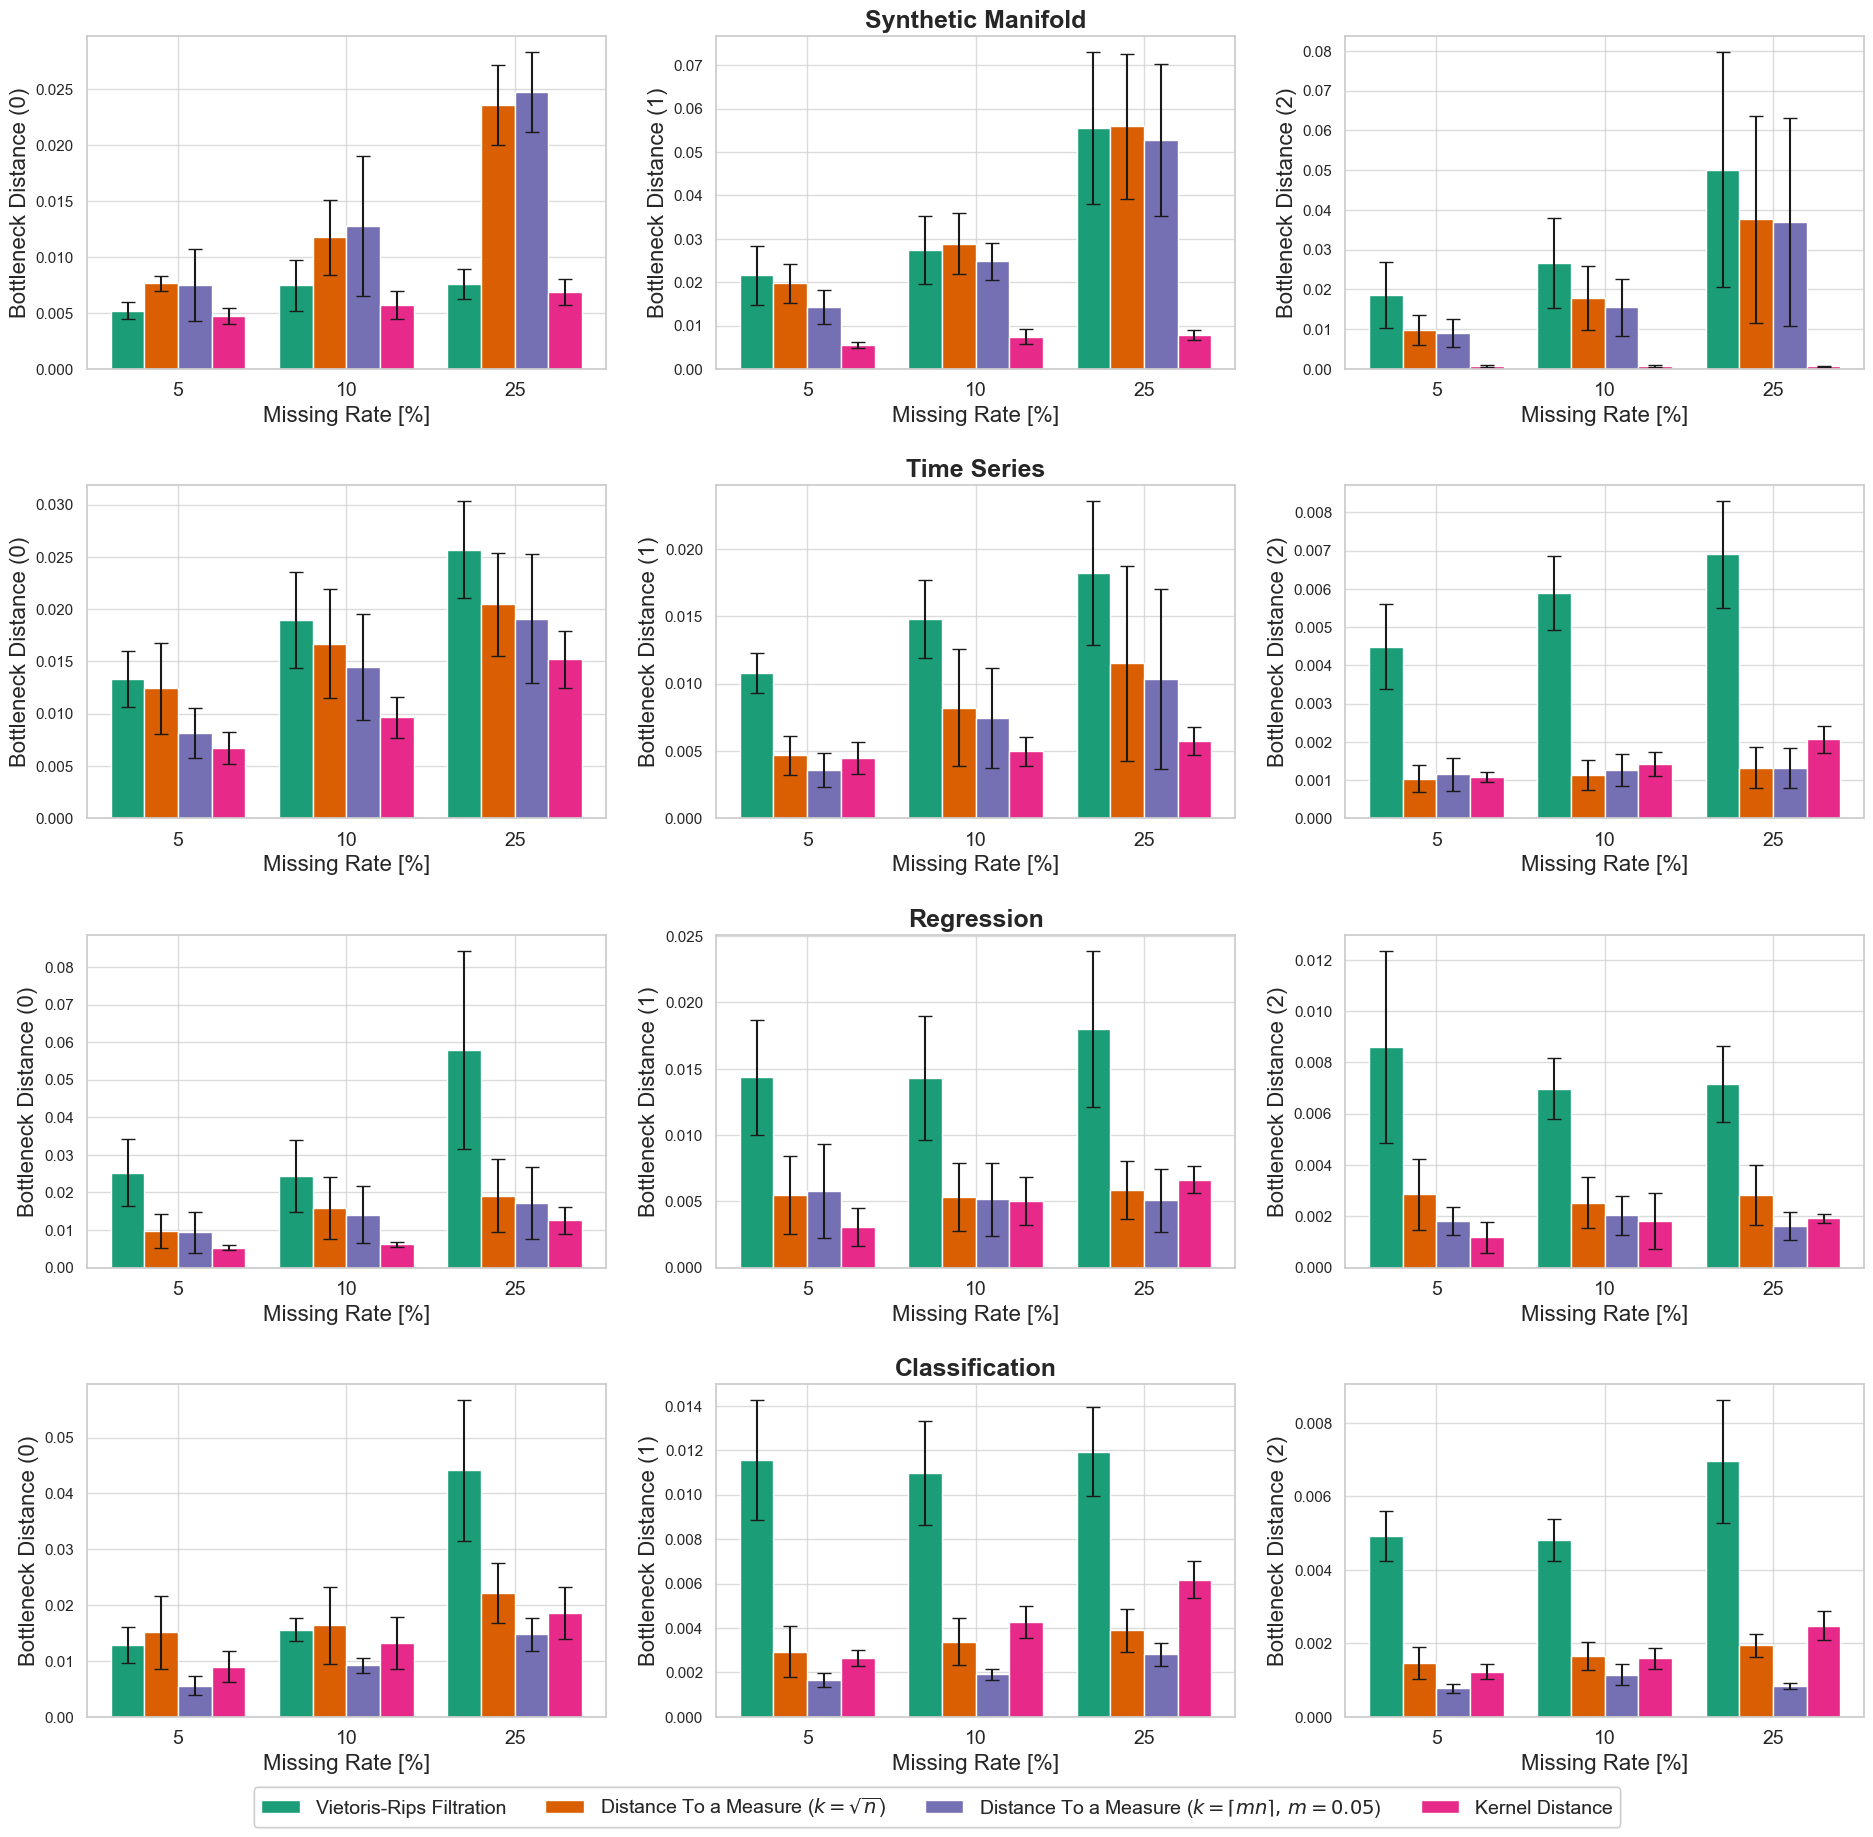

In [13]:
df = group_results(
    csv=IMPACT_TDA,
    group=[DATASET, TDA_METHOD, DIMENSION, MISSING_RATE],
    metrics=COLLECTIONS[TDA_METRIC_SHORT]
)

for m, metric in enumerate(COLLECTIONS[TDA_METRIC_SHORT]):
    fig, axes = setup_figure(
        rows=len(COLLECTIONS[DATASET_TYPE]),
        cols=len(DIMENSIONS)
    )

    for i, dataset_type in enumerate(COLLECTIONS[DATASET_TYPE]):
        df_filtered = df[df[DATASET].isin(COLLECTIONS[dataset_type])].copy()

        for dim in DIMENSIONS:
            ax = axes[i][dim]
            df_stats, x, width = boxplot_stats(
                df=df_filtered, 
                filter=df_filtered[DIMENSION] == dim, 
                group=[MISSING_RATE, TDA_METHOD], 
                metric=metric,
                steps=COLLECTIONS[MISSING_RATE], 
                ticks=COLLECTIONS[TDA_METHOD]
            )

            for j, imp in enumerate(COLLECTIONS[TDA_METHOD]):
                mean, sem = compute_mean_sem(
                    type=TDA_METHOD,
                    data=df_stats,
                    group=MISSING_RATE,
                    filter=df_stats[TDA_METHOD] == imp
                )

                format_axes(
                    type=TDA_METHOD, 
                    ax=ax,
                    x_label=LABEL[MISSING_RATE],
                    y_label=f'{LABEL[metric]} ({dim})',
                    ticks=x + width*(len(COLLECTIONS[TDA_METHOD])-1)/2,
                    tick_labels=COLLECTIONS[MISSING_RATE],
                    title=dim==1,
                    title_label=LABEL[dataset_type]
                )
                plot_data(
                    type=TDA_METHOD,
                    ax=ax, mean=mean, sem=sem,
                    label=LABEL[imp],
                    color=plt.get_cmap(COLOR_MAP[TDA_METHOD])(COLLECTIONS[TDA_METHOD].index(imp)),
                    x=x+j*width,
                    width=width
                )

        legend(
            axes=axes[0],
            fig=fig, 
            cols=len(COLLECTIONS[TDA_METHOD]),
            bbox=(0.5, -0.025)
        )

    plot(fig, f'../figures/appendix/tda_dataset_{topological_error[m]}.svg')